## Hausarbeit Analyse technischer Daten
In dieser Hausarbeit soll ein Datensatz des deutschen Zentrums für Luft- und Raumfahrt analysiert werden.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import scipy.stats
import scipy.spatial
from tqdm.notebook import trange, tqdm

import report

pd.options.display.float_format = "{:.3f}".format

### Datenanalyse
Die Daten liegen als hdf5 Datei vor. Mitgegeben war eine Funktion, um die Daten als pandas DataFrame zu laden. Diese Funktion wurde leicht angepasst und in eine separate Datei ausgelagert. Weiter wird in dem Datenframe errechnete Spalten hinzugefügt, die die Geschwindigkeit, die zurückgelegte Strecke, fft Koeffizienten, und das Schienenprofil aus der zweifach integrierten vertikalen Beschleunigung enthalten.

Die Daten sind in Fahrten der Lokomotive (`journey`) unterteilt. An einer Achse sind auf beiden Seiten Beschleunigungssensoren (ADC) angebracht, zusätzlich gibt es noch eine `Inertial measurement unit` (IMU). Laut beschreibung ist die Samplerate der Beschleunigungssensoren 20625 Hz.

Ziel ist es, aus den Daten Anomalien zu finden, die auf Schadstellen in den Schienen hinweisen. Es gibt nur diese Sensordaten, keine Labels, so das wir uns auf unüberwachtes Lernen beschränken müssen. Zudem sind die Daten nicht geolokalisiert, sodass wir nicht mittels überlagerung auf einer Karte zumindest Weichen und Kurven erkennen können.

In [2]:
import data

In [3]:
# we print the first and last summary of the data
for j in range(data.count_journeys())[::data.count_journeys()-1]:
    print('Journey ' + str(j) + ':')
    for _, sensor in enumerate(data.get_sensors()):
        df = data.read_data(j, sensor)
        print('  ' + sensor + ': ' + str(len(df)) + ' samples')

Journey 0:
  ADC1: 1441792 samples
  ADC2: 1441792 samples
  IMU: 7090 samples
Journey 17:
  ADC1: 782336 samples
  ADC2: 784384 samples
  IMU: 3891 samples


Wir bitten Pandas uns mit den Daten vertraut zu machen.

In [4]:
data.read_data(jrn=0, source='ADC1').head(2)

,ch0,ch1,ch2,ch3,time,speed,trackID,vehicle_orientation,track_distance,direction,ch0_fft,distance,ch0_local_velocity,ch0_local_distance
0,-0.109,0.047,-0.023,0.004,2020-01-24 14:44:43.080495104,0.000,1664,1,10.399,1.000,0.005,0.000,0.000,0.000
1,-0.064,-0.039,-0.014,0.004,2020-01-24 14:44:43.080543488,0.000,1664,1,10.399,1.000,0.002,0.000,0.000,0.000


In [5]:
data.read_data(jrn=0, source='ADC1').describe()

,ch0,ch1,ch2,ch3,time,speed,trackID,vehicle_orientation,track_distance,direction,ch0_fft,distance,ch0_local_velocity,ch0_local_distance
count,1441792.000,1441792.000,1441792.000,1441792.000,1441792,1441792.000,1441792.000,1441792.000,1441792.000,1441792.000,1441792.000,1441792.000,1441792.000,1441792.000
mean,0.005,-0.025,0.001,0.314,2020-01-24 14:45:18.033004288,1.781,1633.843,1.000,42.224,1.000,0.001,58.718,0.000,0.000
min,-175.760,-47.872,-91.508,-0.274,2020-01-24 14:44:43.080495104,0.000,1612.000,1.000,0.006,1.000,0.000,0.000,0.000,0.000
25%,-0.739,-0.354,-0.404,0.004,2020-01-24 14:45:00.556749824,0.000,1612.000,1.000,11.414,1.000,0.000,6.317,0.000,0.000
50%,-0.001,-0.020,0.001,0.005,2020-01-24 14:45:18.033004032,2.154,1612.000,1.000,33.503,1.000,0.000,53.649,0.000,0.000
75%,0.698,0.304,0.414,0.006,2020-01-24 14:45:35.509258752,3.190,1664.000,1.000,75.959,1.000,0.001,111.932,0.000,0.000
max,87.960,68.918,67.506,3.375,2020-01-24 14:45:52.985513216,3.640,1664.000,1.000,88.534,1.000,0.075,124.532,0.009,0.000
std,3.357,1.118,1.574,0.927,NaN,1.405,25.666,0.000,30.706,0.000,0.003,48.701,0.000,0.000


In [6]:
data.read_data(jrn=0, source='IMU').head(2)

,timestamp,acc_x,acc_y,acc_z,ang_vel_x,ang_vel_y,ang_vel_z,gyro_x,gyro_y,gyro_z,orientation_x,orientation_y,orientation_z,orientation_w,roll,pitch,yaw
0,1579877082.632,9.849,-0.585,-0.214,0.017,0.007,-0.010,0.017,0.007,-0.010,0.209,-0.678,0.238,0.664,-97.432,-87.372,134.293
1,1579877082.635,9.731,-0.450,-0.127,0.023,0.005,-0.008,0.023,0.005,-0.008,0.209,-0.678,0.238,0.664,-97.447,-87.368,134.311


In [7]:
data.read_data(jrn=0, source='IMU').describe()

,timestamp,acc_x,acc_y,acc_z,ang_vel_x,ang_vel_y,ang_vel_z,gyro_x,gyro_y,gyro_z,orientation_x,orientation_y,orientation_z,orientation_w,roll,pitch,yaw
count,7090.000,7090.000,7090.000,7090.000,7090.000,7090.000,7090.000,7090.000,7090.000,7090.000,7090.000,7090.000,7090.000,7090.000,7090.000,7090.000,7090.000
mean,1579877118.047,9.759,-0.478,-0.081,0.017,0.007,-0.011,0.017,0.007,-0.011,0.208,-0.679,0.237,0.663,-101.317,-87.224,137.994
std,20.467,0.226,0.259,0.171,0.006,0.007,0.009,0.006,0.007,0.009,0.009,0.003,0.005,0.003,9.567,0.964,9.864
min,1579877082.632,7.967,-2.519,-1.168,-0.015,-0.036,-0.087,-0.015,-0.036,-0.087,0.186,-0.684,0.227,0.655,-130.391,-89.726,95.062
25%,1579877100.327,9.654,-0.587,-0.166,0.014,0.003,-0.016,0.014,0.003,-0.016,0.200,-0.682,0.234,0.661,-106.790,-87.650,132.662
50%,1579877118.050,9.760,-0.464,-0.078,0.018,0.007,-0.011,0.018,0.007,-0.011,0.210,-0.680,0.238,0.663,-99.928,-87.306,136.776
75%,1579877135.773,9.853,-0.352,0.008,0.022,0.011,-0.007,0.022,0.011,-0.007,0.214,-0.677,0.240,0.664,-96.381,-86.851,144.352
max,1579877153.464,13.737,1.171,1.149,0.038,0.045,0.054,0.038,0.045,0.054,0.225,-0.667,0.251,0.674,-58.084,-84.399,167.429


### Visualisierung der Daten
Hier sollen einmal alle Sensordaten über alle Journeys visualisiert werden. Die X-Achse ist jeweils die Zei tund die Y-Achse der Wert des Sensors. Journeys sind zur Abgrenzung grau hinterlegt.

  0%|          | 0/18 [00:00<?, ?it/s]

<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

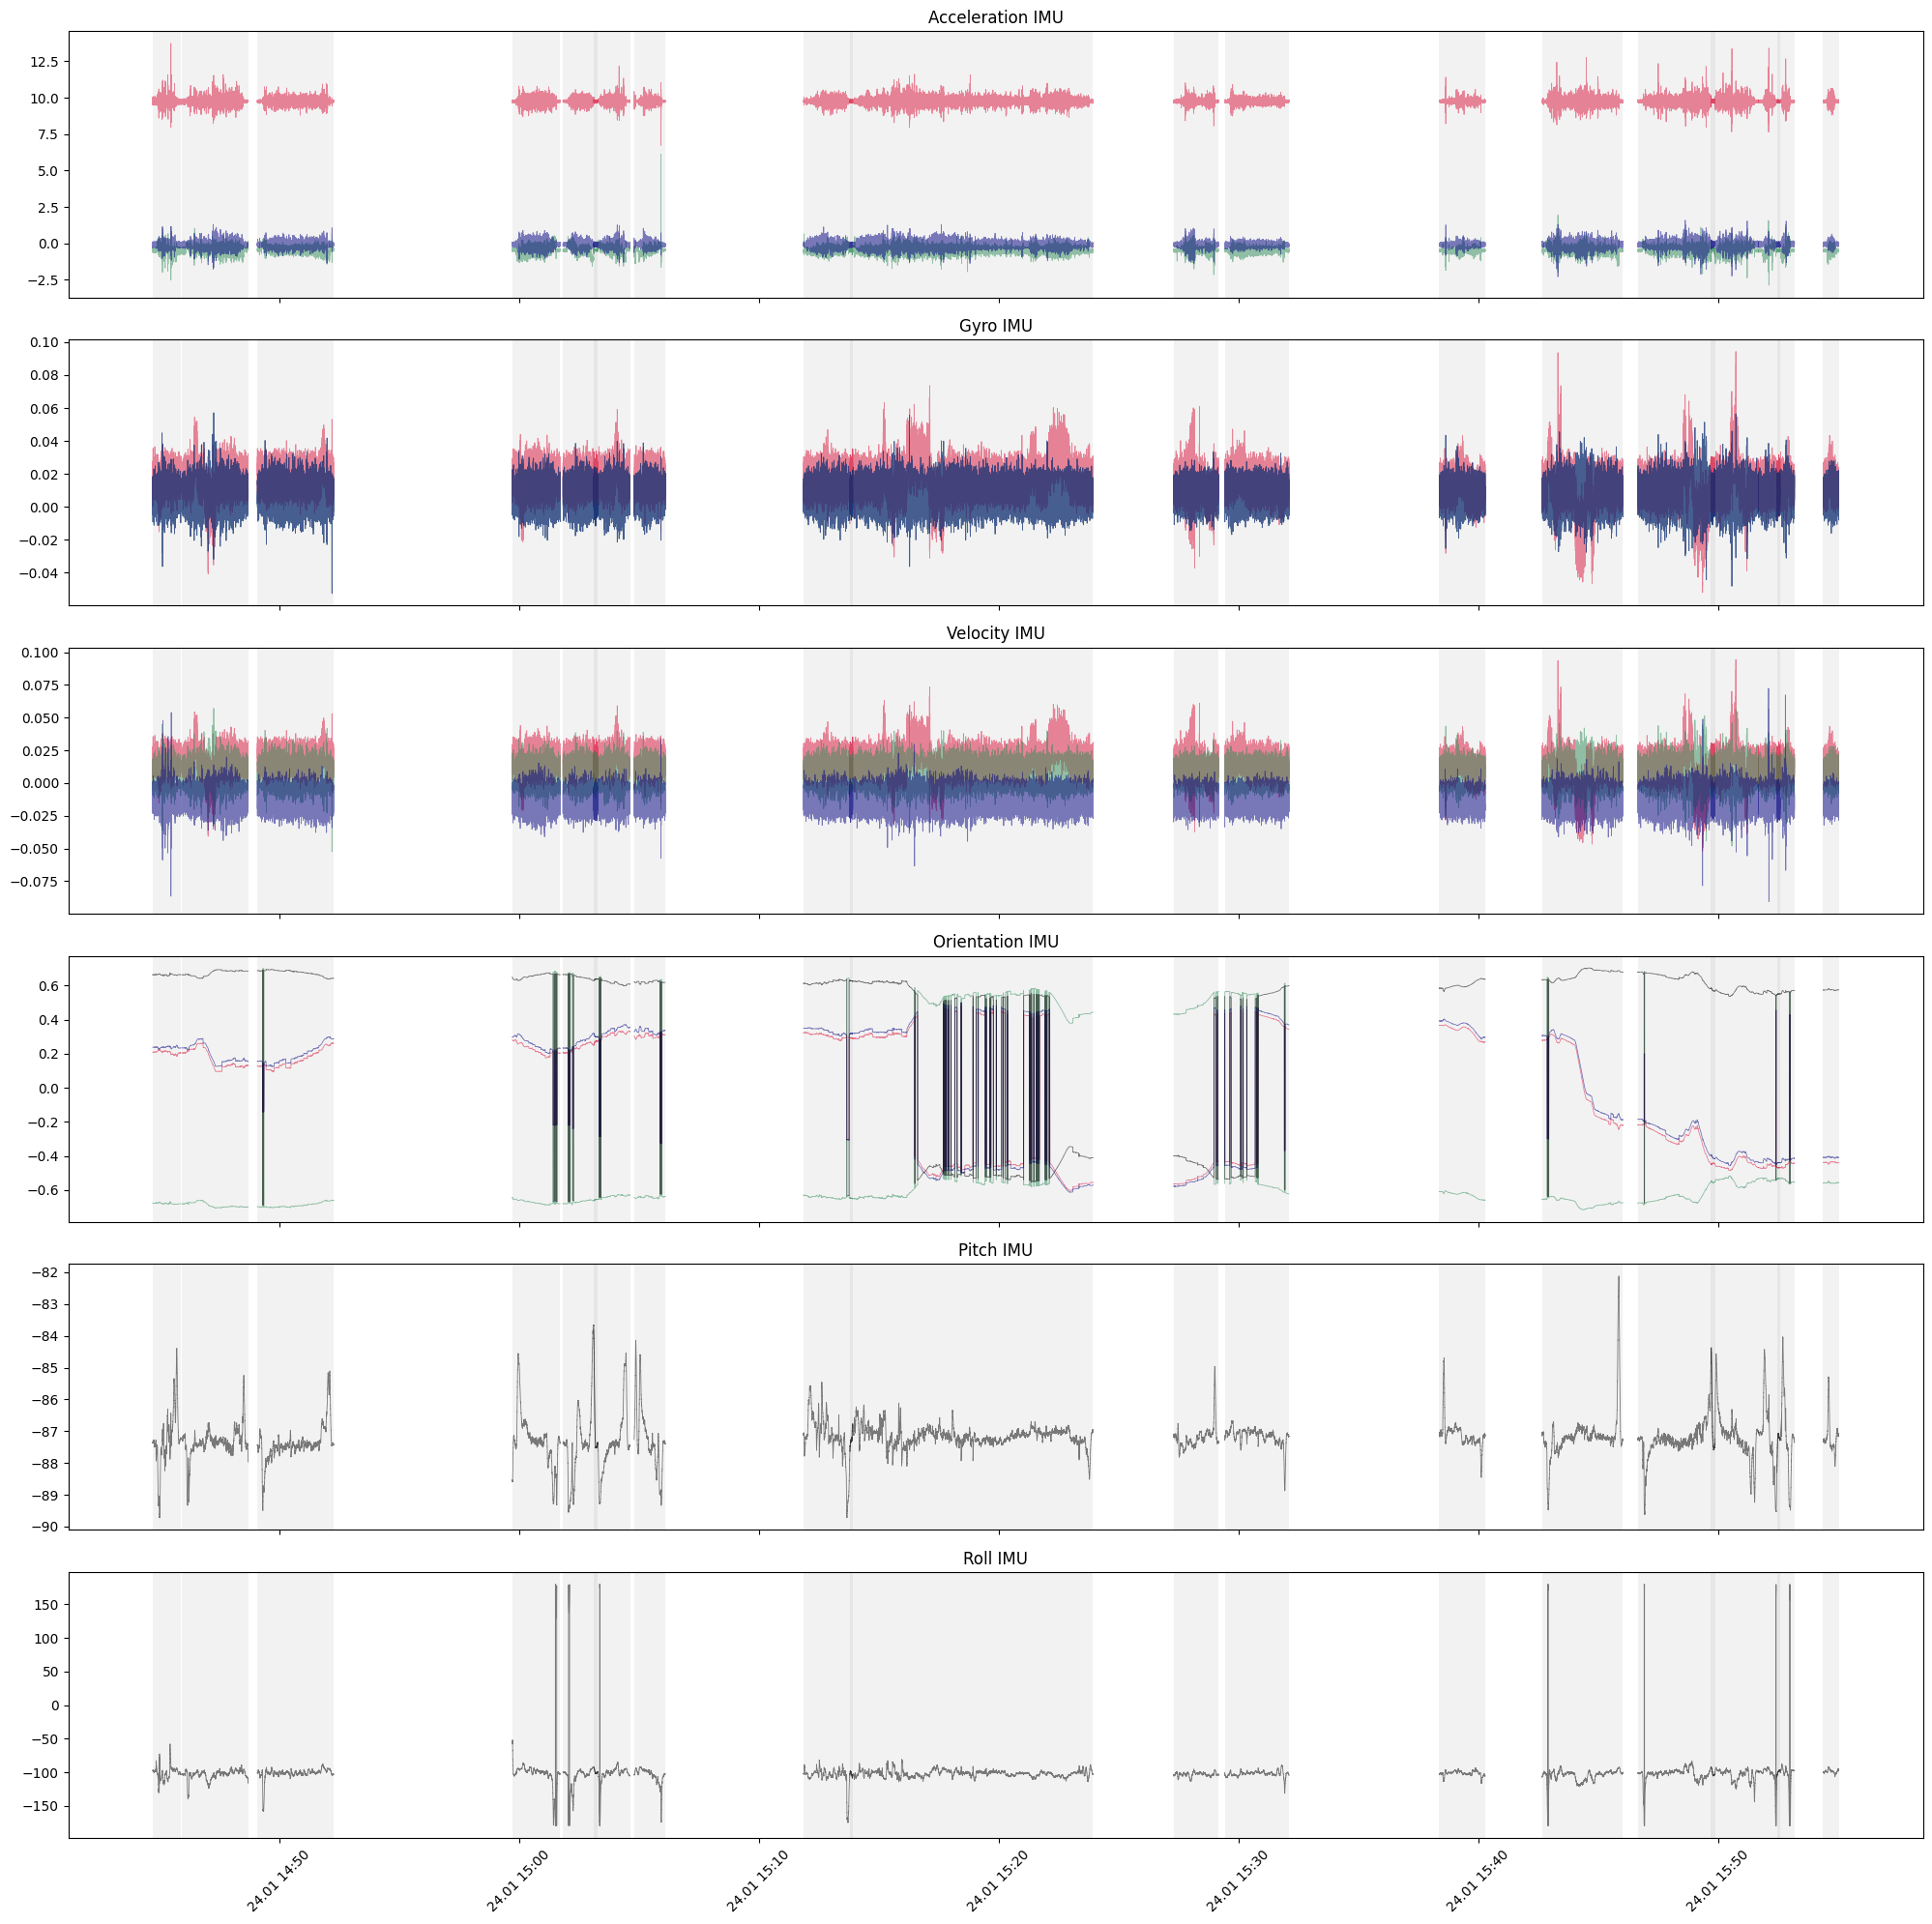

In [8]:
report.plot_imu_sensors()

  0%|          | 0/18 [00:00<?, ?it/s]

<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

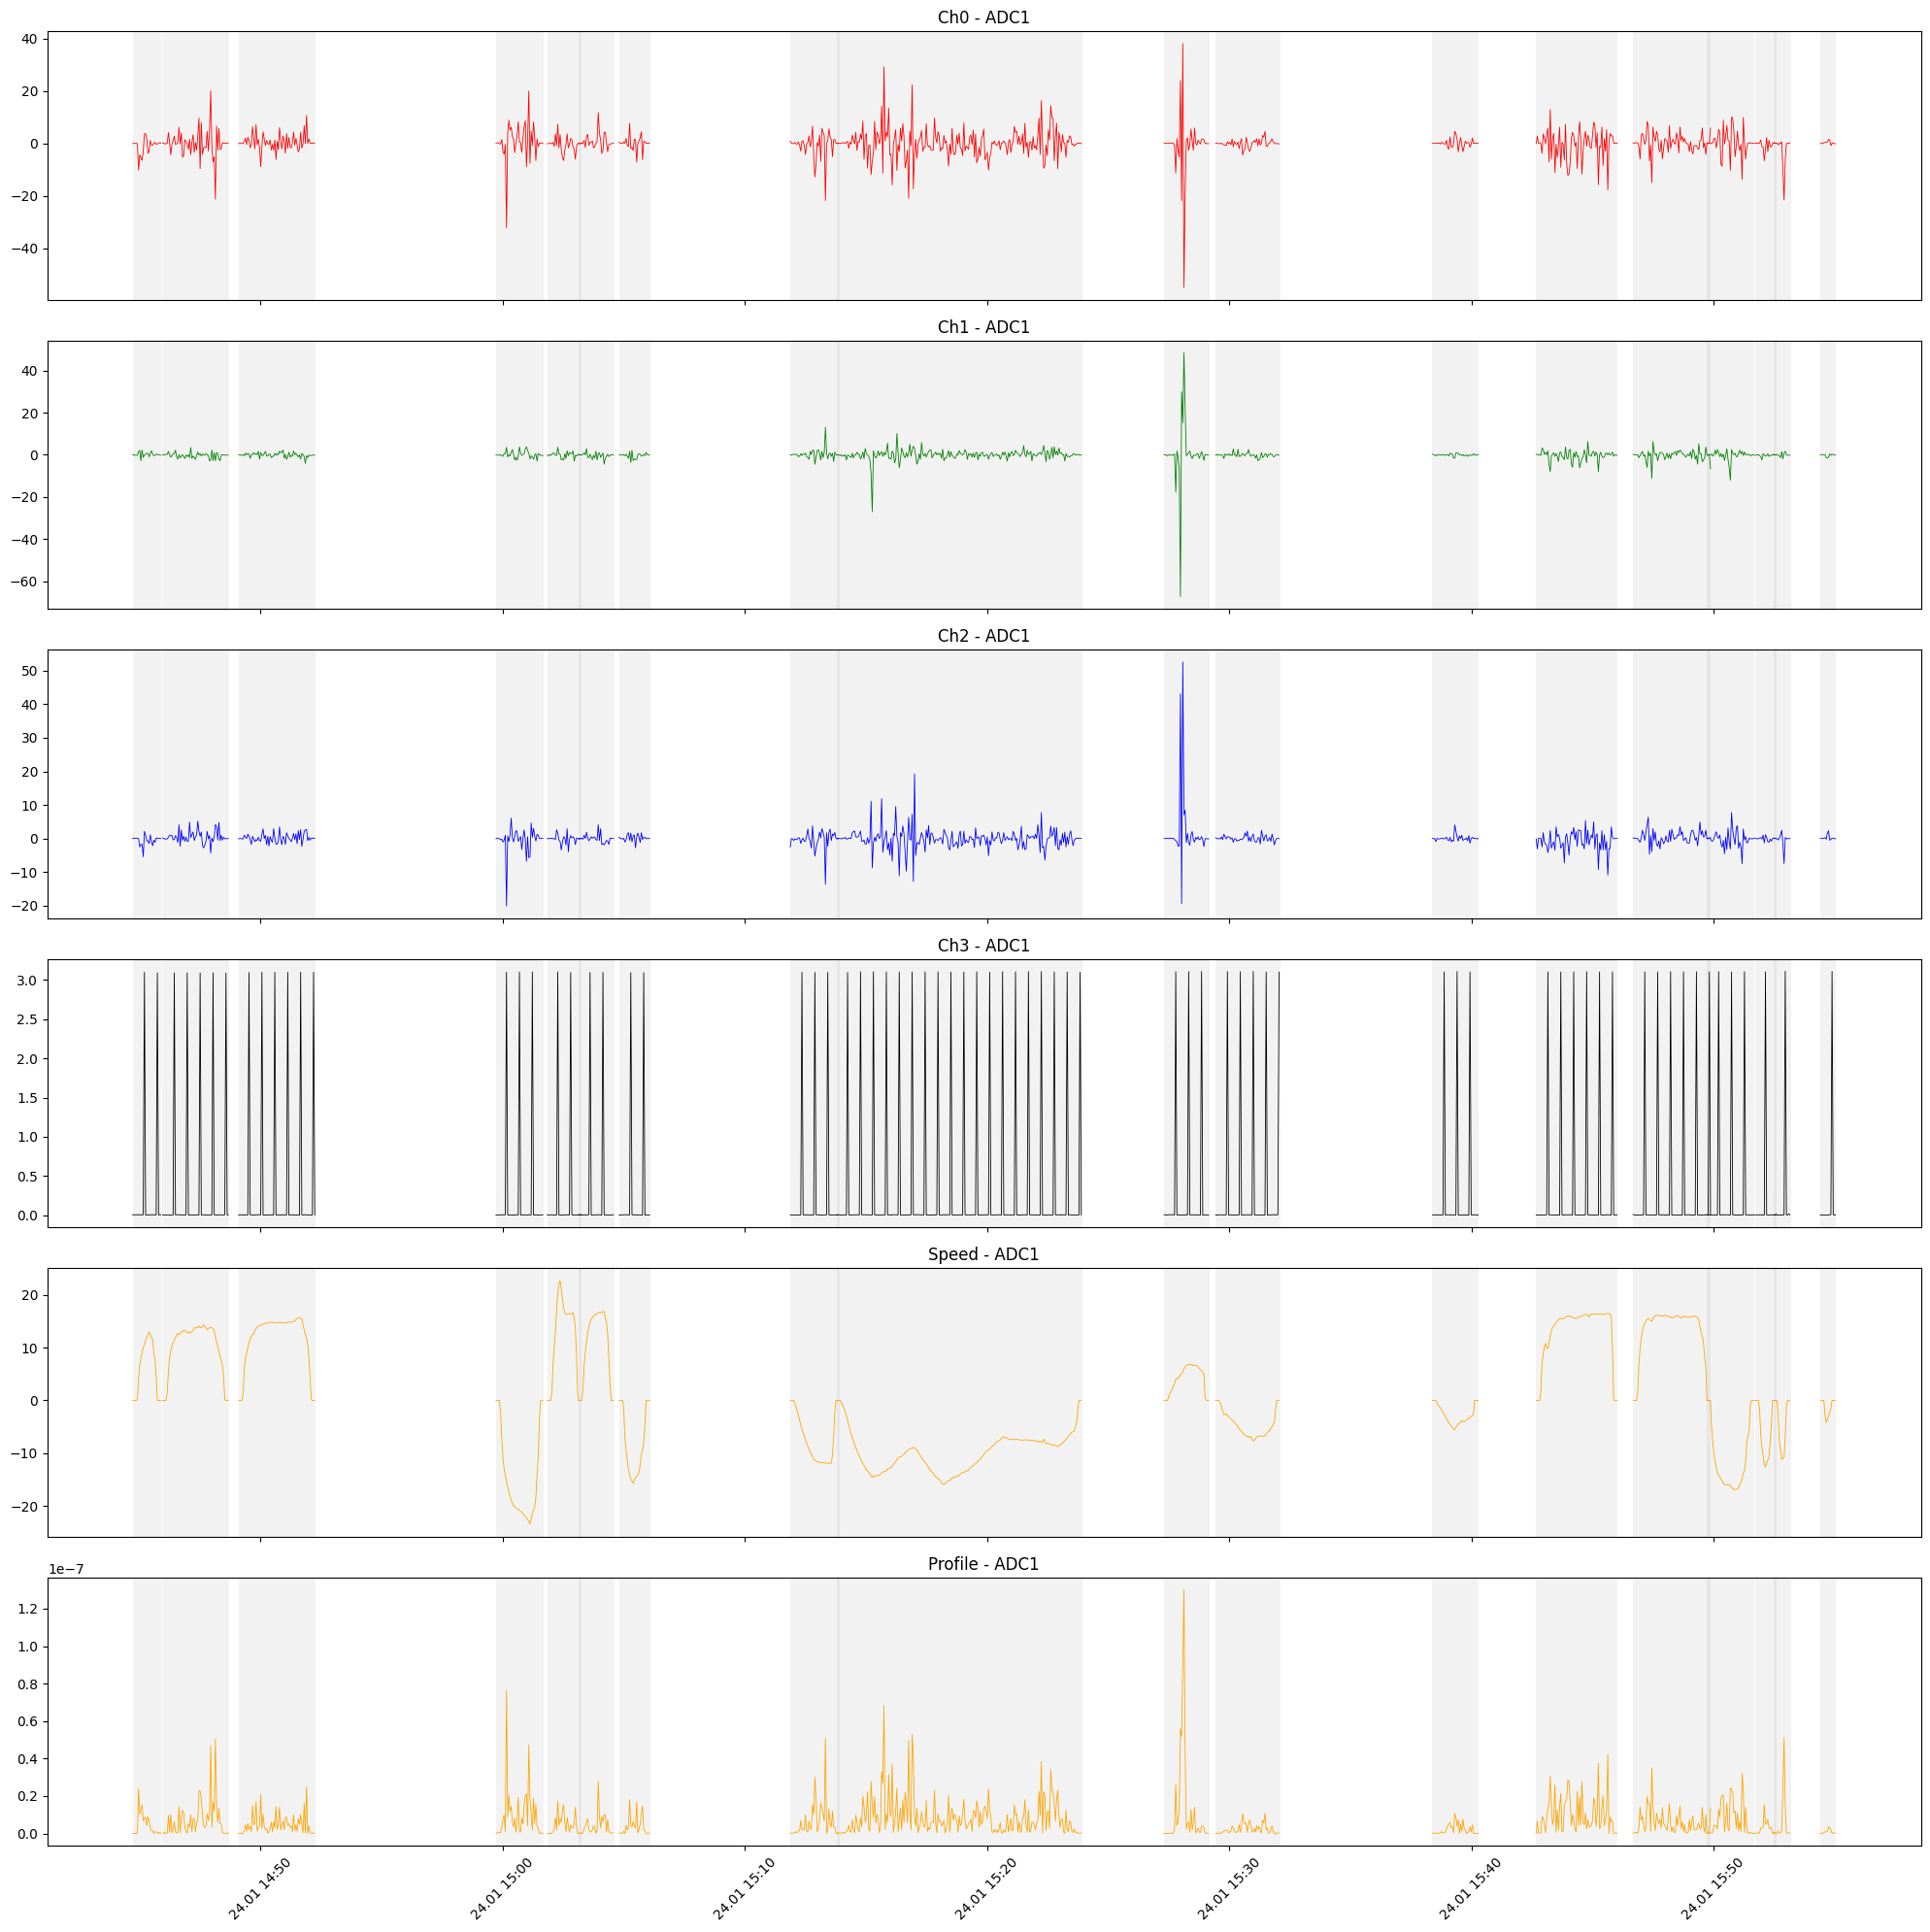

In [9]:
report.plot_sensors_adc(adc=1)

  0%|          | 0/18 [00:00<?, ?it/s]

<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

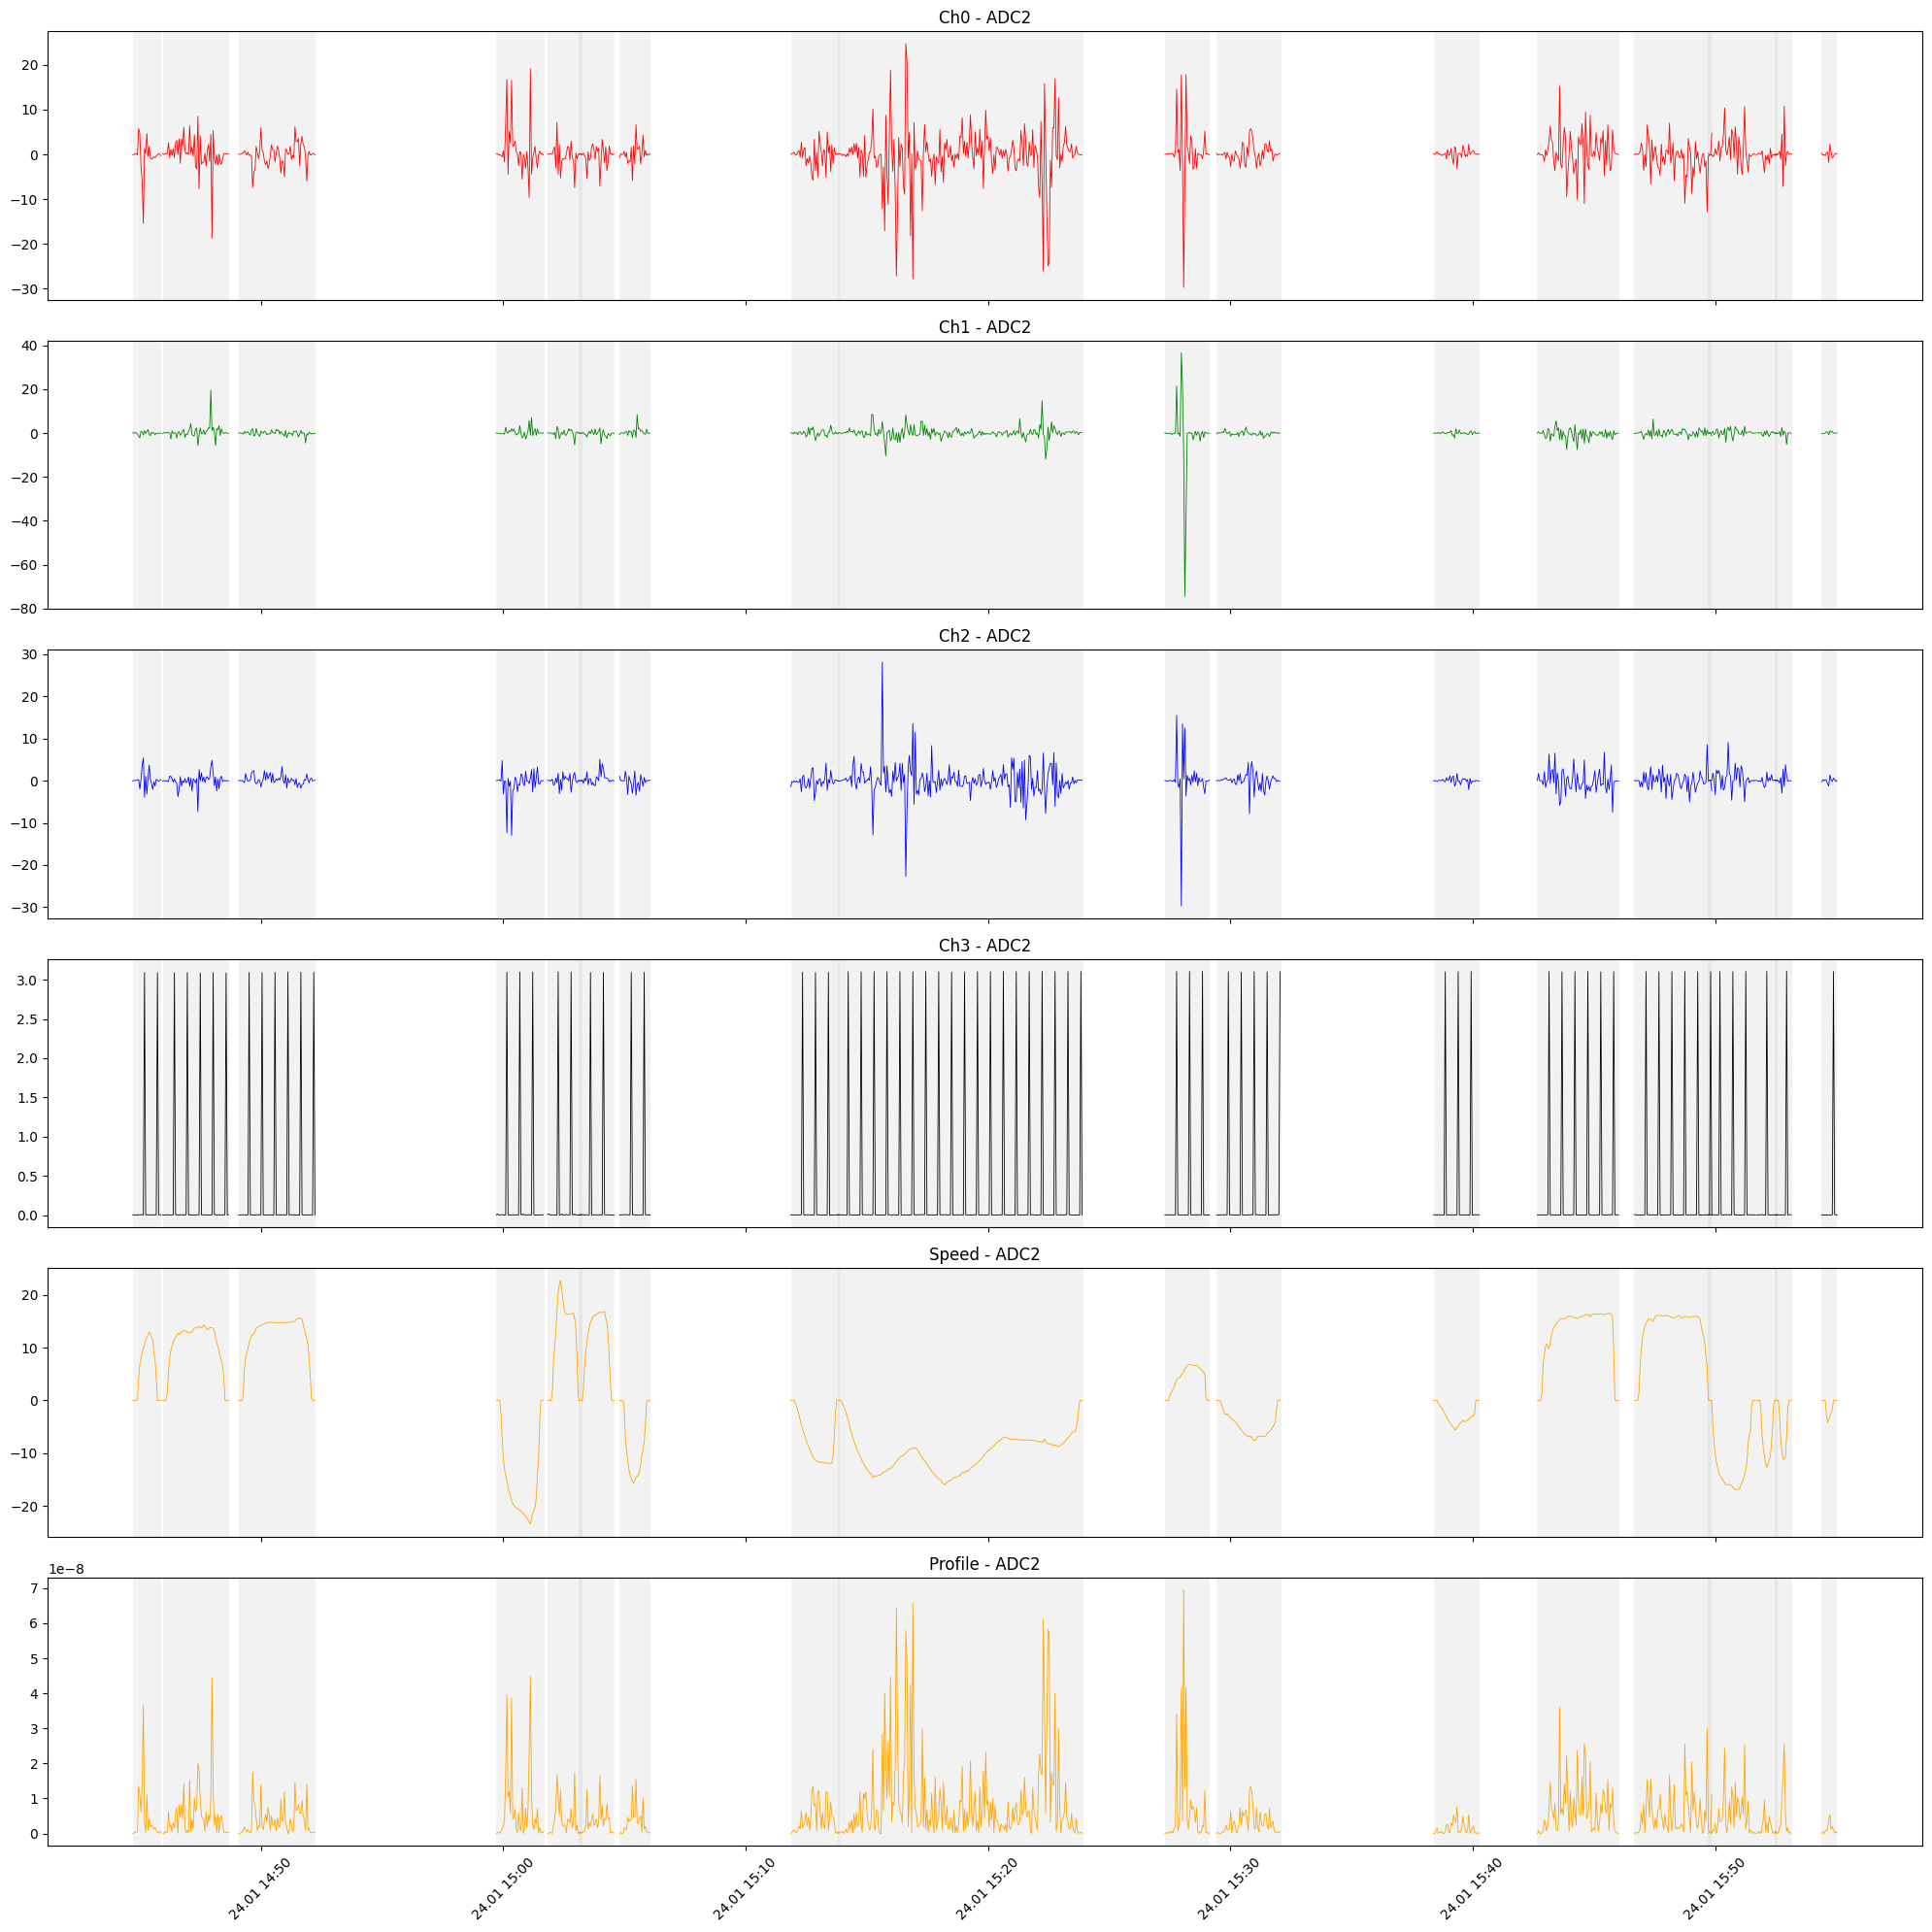

In [10]:
report.plot_sensors_adc(adc=2)

Mithilfe der longitudinalen und lateralen Beschleunigung können wir die Fahrt der Lokomotive visualisieren, indem wir die Beschleunigung doppelt integrieren. Die meisten Fahrten beschränken sich auf eine kurze, gerade Strecke, Kurven und Weichen sind für mich schwer auszumachen.

  0%|          | 0/18 [00:00<?, ?it/s]

<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

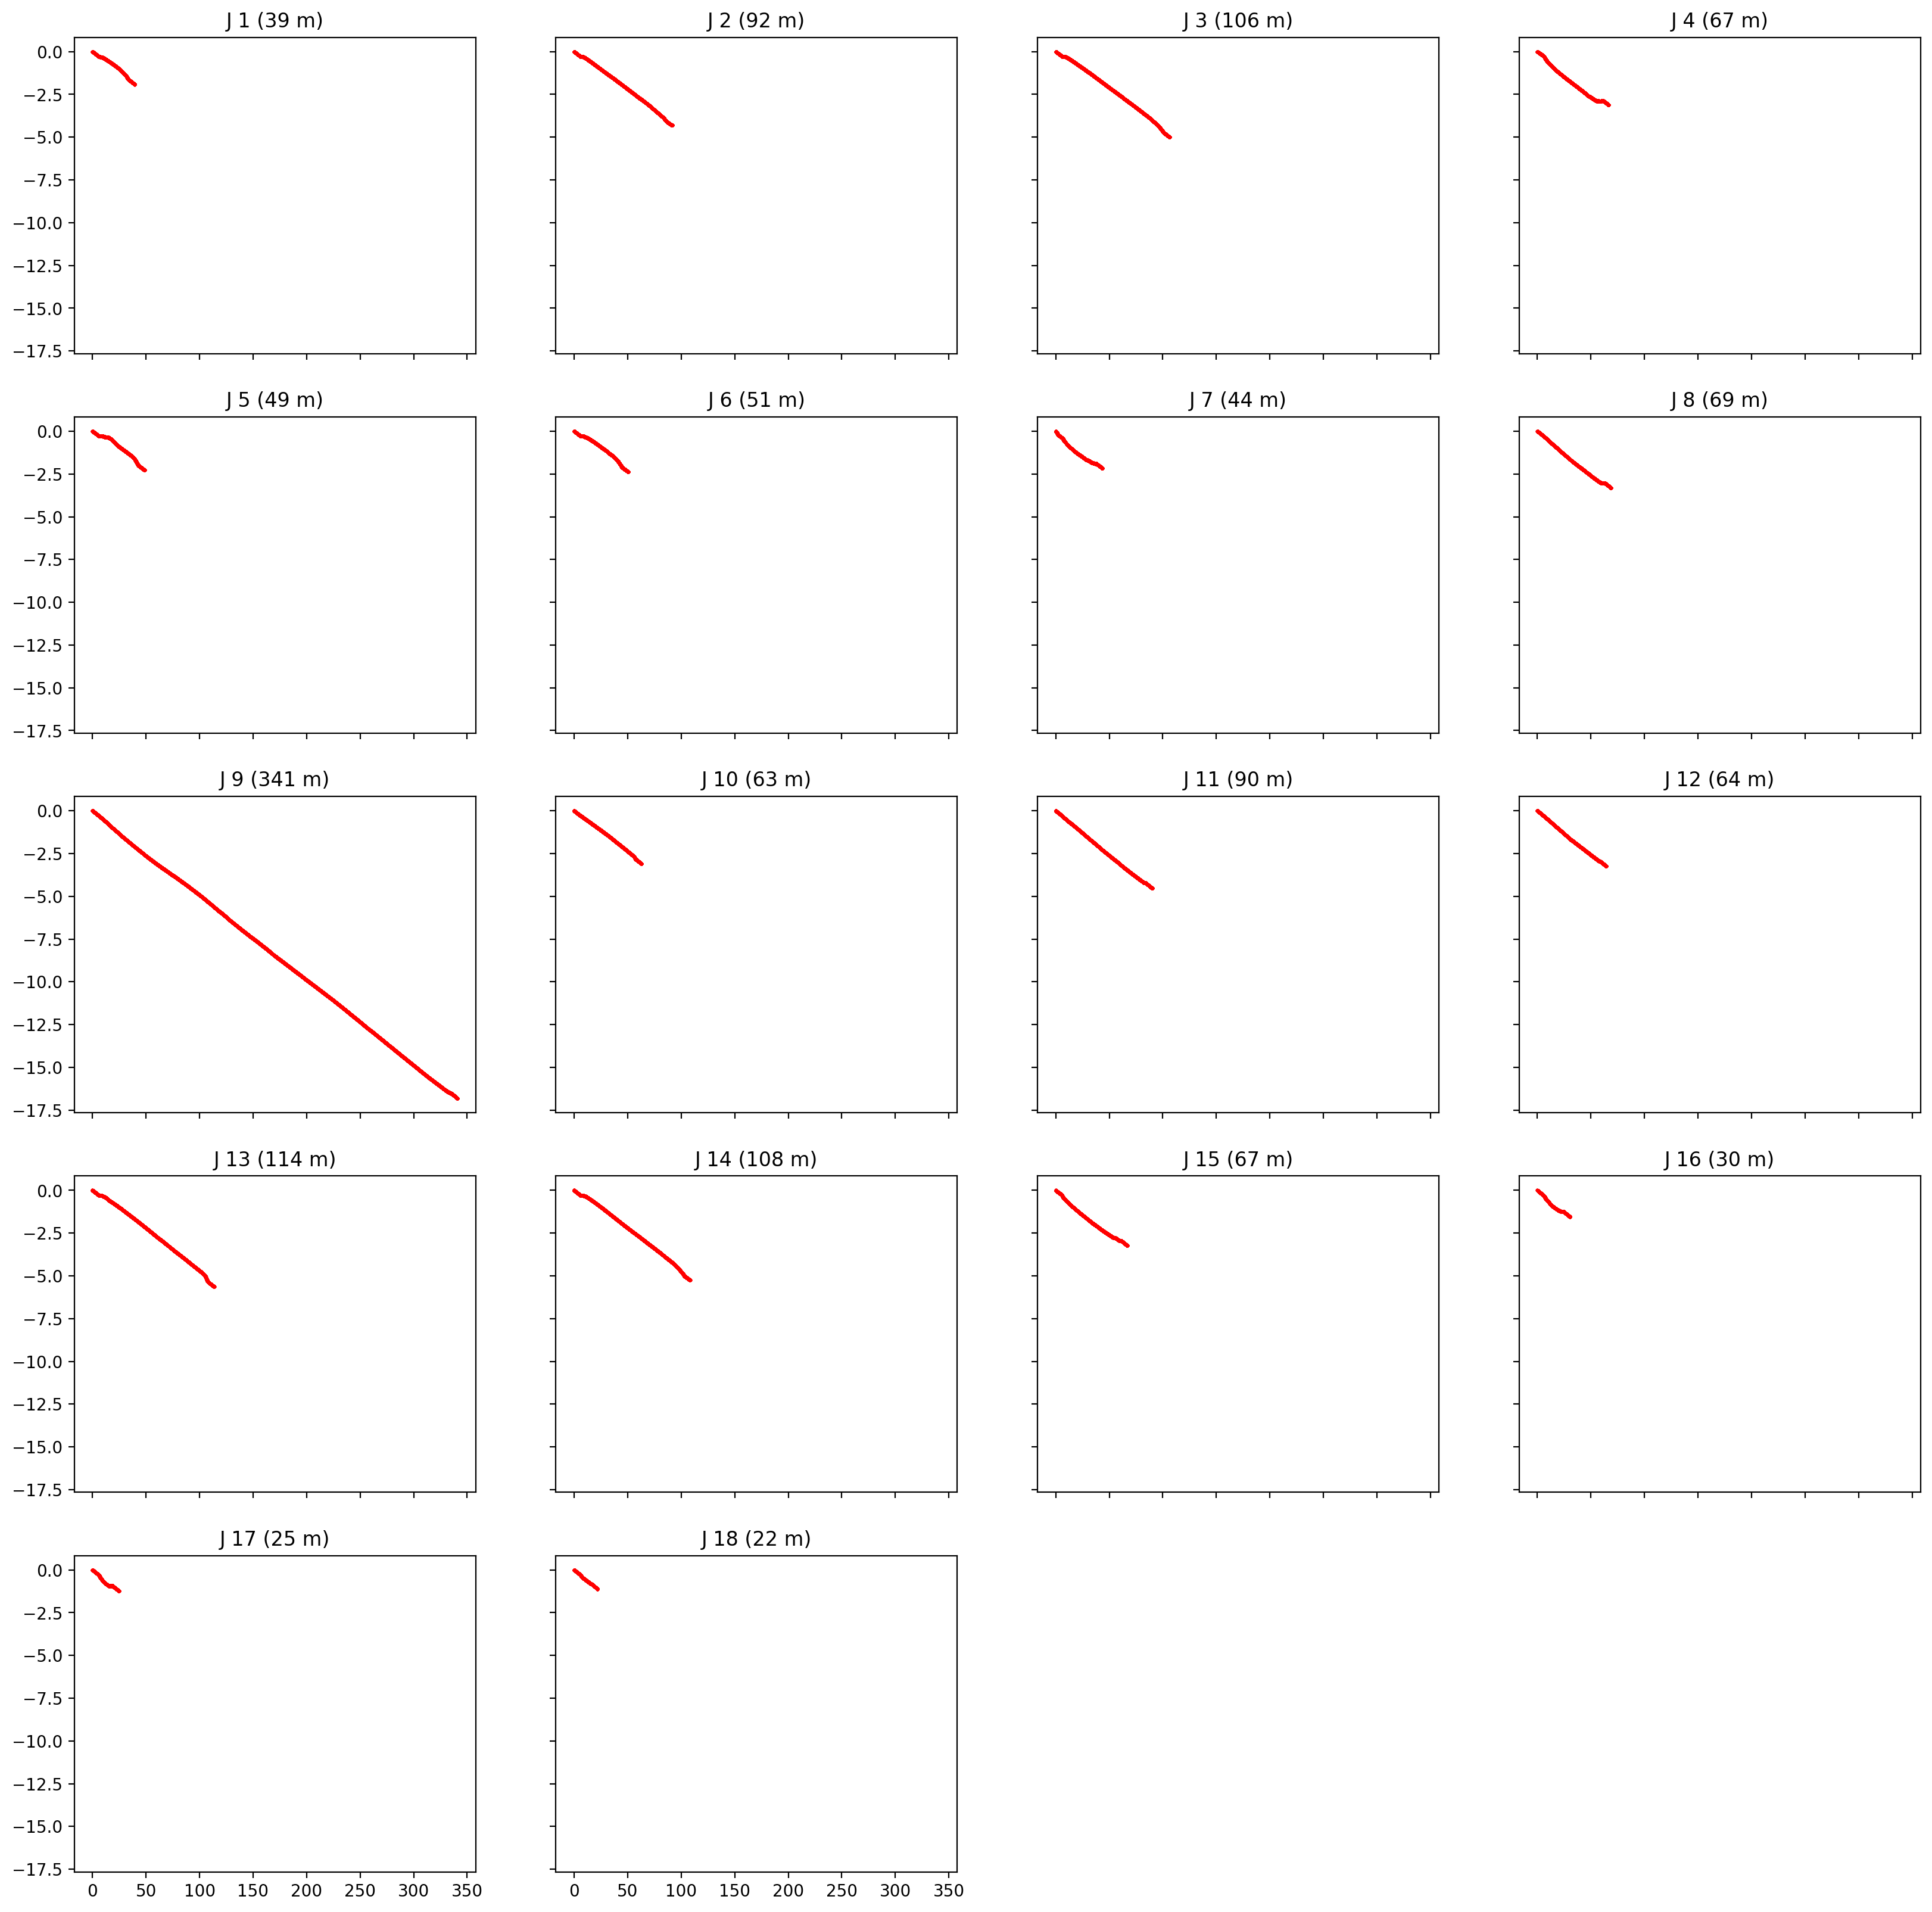

In [11]:
report.plot_positions()

#### Aufteilung in Bins
Dadurch, dass wir jederzeit wissen, wie schnell die Lokomotive ist, können wir die gefahrene Strecke in gleich große Abschnitte einteilen. Diese Abschnitte nennen wir Bins. Wir können nun die Daten in diese Abschnitte aufteilen und die Daten in jedem Bin einzeln analysieren.
Als Erstes teilen wir die Daten in Bins zu 30 cm Länge auf und errechnen die via fft die Frequenzen der vertikalen Beschleunigung (`ch0`-Signal) in jedem Bin.

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

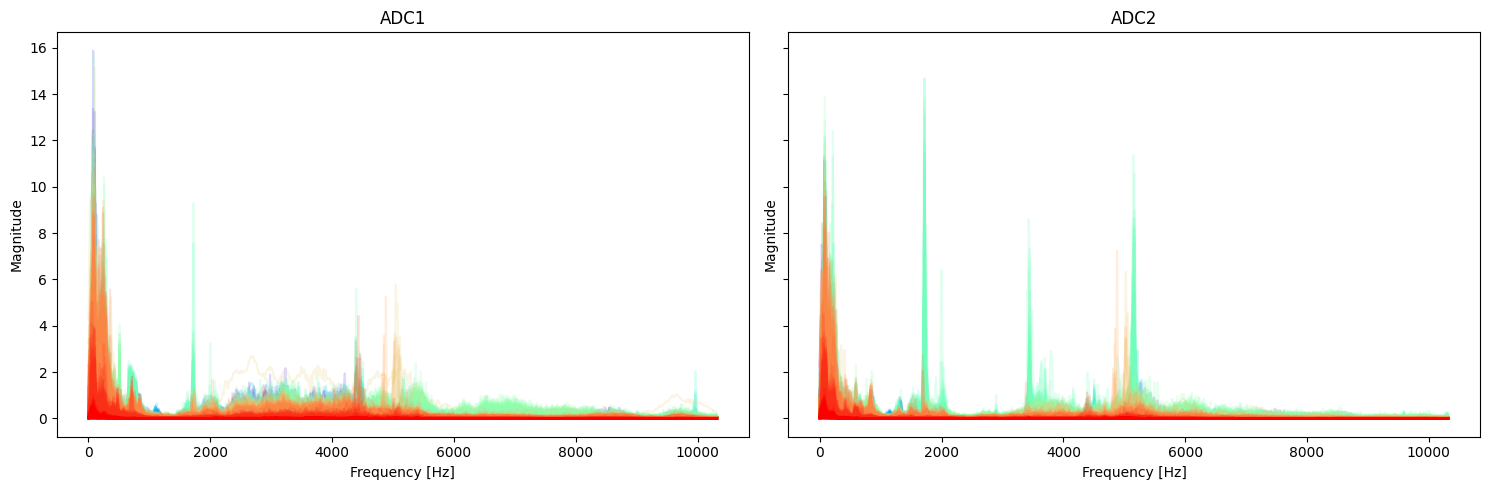

In [12]:
report.plot_frequencies_in_bins(sources=['ADC1', 'ADC2'], chunk_length=0.3)

### Feature Engineering
Der erste Ansatz ist ein Feature Engineering. Wir rechnen für jeden Bin einen Featurevektor aus, mit dem wir später die Klassifikation durchführen können. Um die Dimension des Featurevektors zu reduzieren errechnen wir eine Principle Component Analysis (PCA) und nutzen nur die ersten 3 Hauptkomponenten.
Als Features nutzen wir
- das artithmetische Mittel der vertikalen Beschleunigung
- den root mean square (RMS) der vertikalen Beschleunigung
- das 25, 50 und 75 Quantil der vertikalen Beschleunigung
- den maximalen absoluten Wert der vertikalen Beschleunigung
- die Starnardabweichung der vertikalen Beschleunigung
- den Peak to Peak Wert der vertikalen Beschleunigung
- die Kurtosis der vertikalen Beschleunigung
- die Skewness der vertikalen Beschleunigung
- und die Entropie der vertikalen Beschleunigung


Diese Liste wurde aus diesem [Paper](https://arxiv.org/pdf/2101.11539.pdf) inspiriert

Journey:   0%|          | 0/18 [00:00<?, ?it/s]

Journey 1 explained variances: [0.5008994  0.16814738 0.12753538], total: 79.66%
Journey 2 explained variances: [0.52197526 0.1457443  0.11115922], total: 77.89%
Journey 3 explained variances: [0.47836727 0.1724099  0.13812448], total: 78.89%
Journey 4 explained variances: [0.49894808 0.16306561 0.12408072], total: 78.61%
Journey 5 explained variances: [0.50045956 0.18010669 0.13620778], total: 81.68%
Journey 6 explained variances: [0.50911715 0.15904759 0.13179066], total: 80.00%
Journey 7 explained variances: [0.50910409 0.17658814 0.13751043], total: 82.32%
Journey 8 explained variances: [0.52555779 0.1535388  0.11102876], total: 79.01%
Journey 9 explained variances: [0.52554755 0.14066887 0.11119359], total: 77.74%
Journey 10 explained variances: [0.5330688  0.18022343 0.10568312], total: 81.90%
Journey 11 explained variances: [0.52705712 0.15813623 0.14138526], total: 82.66%
Journey 12 explained variances: [0.53756568 0.123395   0.11745071], total: 77.84%
Journey 13 explained vari

<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

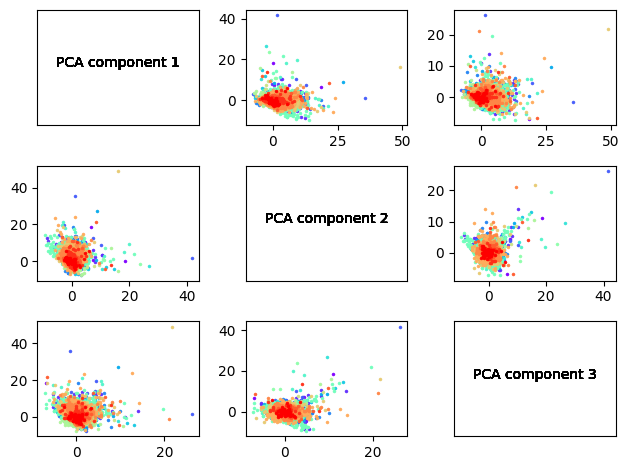

In [13]:
report.conduct_pca_on_featues(source='ADC1', count_components=3, feature_lambda=lambda x: x)

Da hier keine verwertbaren Cluster zu sehen waren, wurde das Signal nochmal mit einer fft transformiert und die Features auf dem Spektrum berechnet.

Journey:   0%|          | 0/18 [00:00<?, ?it/s]

Journey 1 explained variances: [0.67645623 0.20800498 0.07403552], total: 95.85%
Journey 2 explained variances: [0.72337338 0.16970604 0.07857519], total: 97.17%
Journey 3 explained variances: [0.61784658 0.24830375 0.09704834], total: 96.32%
Journey 4 explained variances: [0.61718099 0.22893606 0.11611618], total: 96.22%
Journey 5 explained variances: [0.61083781 0.20689065 0.13453043], total: 95.23%
Journey 6 explained variances: [0.64706699 0.21314897 0.1056438 ], total: 96.59%
Journey 7 explained variances: [0.59714124 0.23322864 0.12431374], total: 95.47%
Journey 8 explained variances: [0.65959049 0.20297198 0.09767446], total: 96.02%
Journey 9 explained variances: [0.67524485 0.19845302 0.08272705], total: 95.64%
Journey 10 explained variances: [0.71513104 0.20808253 0.05640122], total: 97.96%
Journey 11 explained variances: [0.54176931 0.25325849 0.15552579], total: 95.06%
Journey 12 explained variances: [0.64870211 0.21352877 0.09770177], total: 95.99%
Journey 13 explained vari

<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

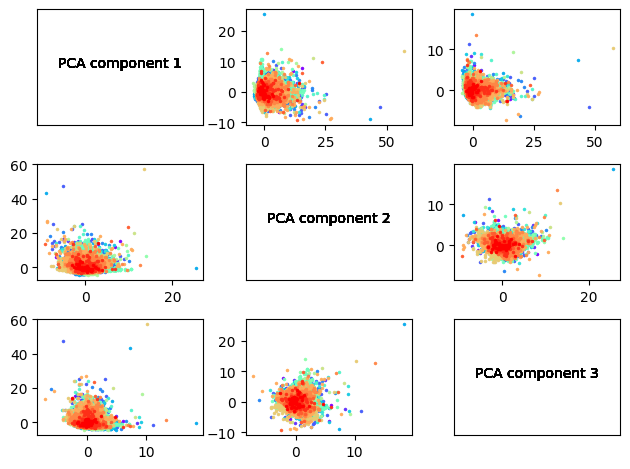

In [14]:
report.conduct_pca_on_featues(source='ADC1', count_components=3, feature_lambda=lambda x: np.abs(np.fft.fft(x)))

Auch hier konnte keine sichtbaren Cluster gefunden werden, obwohl sich die explained Variance erhöht. Deshalb wurde dieser Weg nicht weiter verfolgt und stattdessen andere Ansätze gesucht.

### Ähnlichkeitansatz
Dieser Ansatz basiert auf der Idee, dass bei intakten Schienen und gerader Fahrt die vertikale Beschleunigung auf beiden Achsen ähnlich sein muss. Wenn ein Rad über eine Schadstelle fährt, dann sollte die vertikale Beschleunigung auf der Achse mit der Schadstelle anders sein als auf der anderen Achse. Wir können also die Distanz zwischen den beiden vertikalen Beschleunigungen als Feature nutzen. Eine Achse dient als Bin-Referenz, für die andere Achsen suchen wir die Daten, die in der Zeit des Bins aufgenommen wurden.
Zwei Distanzmaße wurden ausprobiert:
- die Pearson Korrelation der beiden Signale
- das dynamische Time Warping (DTW)

#### Korrelationansatz

  0%|          | 0/414 [00:00<?, ?it/s]

<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

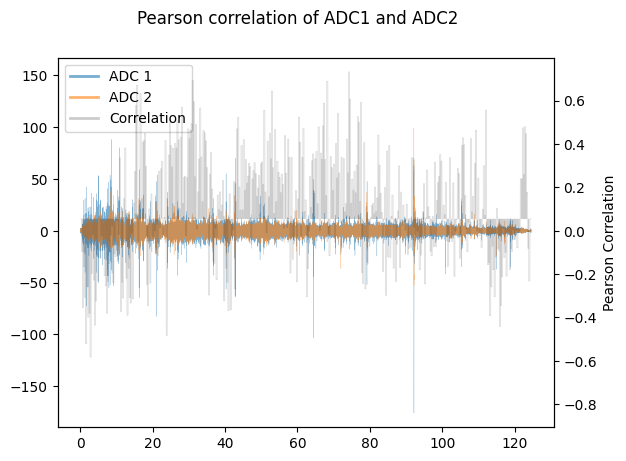

In [15]:
adc1_df = data.read_as_chuncked(0, 'ADC1')
adc2_df = data.read_as_chuncked(0, 'ADC2')

adc1_df["Correlation"] = np.nan
adc2_df["Correlation"] = np.nan

for j in trange(int(np.max(adc1_df["Bin"]))):

    # get the time of the bin
    time_start = np.min( adc1_df[adc1_df["Bin"] == j]["time"])
    time_end = np.max( adc1_df[adc1_df["Bin"] == j]["time"])

    # get the data of the bin by the time
    bin_adc1 = adc1_df.loc[(adc1_df["time"] > time_start) & (adc1_df["time"] < time_end), "ch0"]
    bin_adc2 = adc2_df.loc[(adc2_df["time"] > time_start) & (adc2_df["time"] < time_end), "ch0"]

    length = np.min([len(bin_adc1), len(bin_adc2)])

    # we calculate the correlation of the two signals thanks to Mr. Pearson
    corr, _ = scipy.stats.pearsonr(bin_adc1[:length], bin_adc2[:length])

    adc1_df.loc[(adc1_df["time"] > time_start) & (adc1_df["time"] < time_end), "Correlation"] = corr
    adc2_df.loc[(adc2_df["time"] > time_start) & (adc2_df["time"] < time_end), "Correlation"] = corr

fig, axs1 = plt.subplots()

axs1.plot(adc1_df["distance"], adc1_df["ch0"], linewidth=0.2, alpha=0.6, label="ADC 1")
axs1.plot(adc2_df["distance"], adc2_df["ch0"], linewidth=0.2, alpha=0.6, label="ADC 2")


axs2 = axs1.twinx()

# filter out those where no correlation could be calculated
valid_correlations = adc2_df["Correlation"] != np.nan
axs2.plot(adc2_df[valid_correlations]["distance"], adc2_df[valid_correlations]["Correlation"], c="k",  linewidth=0.4, alpha=0.2, label="Correlation")
axs2.set_ylabel("Pearson Correlation")

# helper function to align both y-axis to the same offset
report.align_yaxis(axs1, axs2)


fig.suptitle("Pearson correlation of ADC1 and ADC2")

h1, l1 = axs1.get_legend_handles_labels()
h2, l2 = axs2.get_legend_handles_labels()
leg = axs1.legend(h1+h2, l1+l2, loc=2)
# set the line width of each legend object
for l in leg.legend_handles:
    l.set_linewidth(2.0)
    
    
plt

Die Hoffnung war, hier Spikes zu sehen, wo die Correlation der beiden Signale stark abfällt. Leider war dies nicht der Fall. Deshalb wurde ein anderer Ansatz gesucht und das DTW ausprobiert. Das DTW ist ein Distanzmaß, dass die Distanz zwischen zwei Zeitreihen berechnet. Es ist invariant gegenüber Verschiebung und Skalierung der Zeitreihen. Wir verwenden die Implementierung aus der [tslearn](https://tslearn.readthedocs.io/en/stable/) Bibliothek.
Die Wahl auf DWT war, dass die beiden Räder unterschiedliche Wege zurücklegen (z.B. in Kurven oder Weichen) und die Zeitreihen daher nicht direkt vergleichbar sind. Das DTW ist invariant gegenüber Verschiebung und Skalierung der Zeitreihen.
Dieser Ansatz wurde aus diesem [Paper](https://arxiv.org/pdf/1810.07758.pdf) inspiriert.

Als Beispiel des DWT-Ansatzes soll einmal die Distanz zwischen zwei zufällig gewählten Bins berechnet und visualisiert werden.

DTW distance: 70.53993665394427


<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

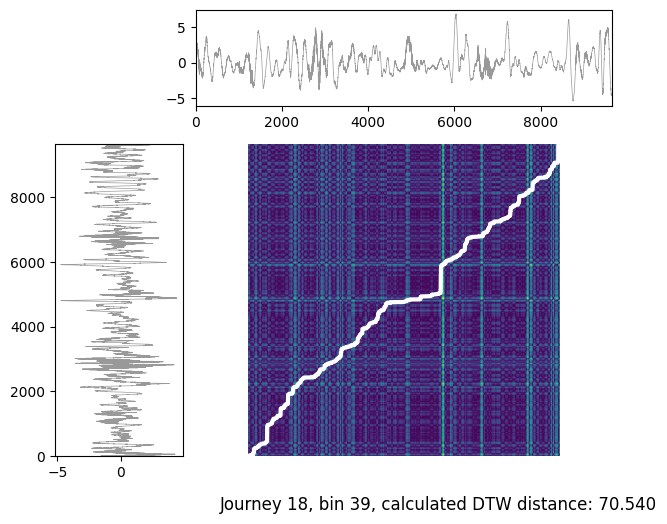

In [16]:
import tslearn.metrics

# shameless inspired from https://tslearn.readthedocs.io/en/stable/auto_examples/metrics/plot_dtw.html

random_journey = np.random.randint(0, data.count_journeys())
adc1_df = data.read_as_chuncked(random_journey, 'ADC1')
adc2_df = data.read_as_chuncked(random_journey, 'ADC2')

random_bin = np.random.randint(0, int(np.max(adc1_df["Bin"])))

# get the time of the bin
time_start = np.min(adc1_df[adc1_df["Bin"] == random_bin]["time"])
time_end = np.max(adc1_df[adc1_df["Bin"] ==random_bin]["time"])

# get the data of the bin by the time
s1 = np.array(adc1_df.loc[(adc1_df["time"] > time_start) & (adc1_df["time"] < time_end), "ch0"])
s2 = np.array(adc2_df.loc[(adc2_df["time"] > time_start) & (adc2_df["time"] < time_end), "ch0"])

# we cut the signals to the same length
s1 = s1[:np.min([len(s1), len(s2)])]
s2 = s2[:np.min([len(s1), len(s2)])]


sz = s1.shape[0]
path, sim = tslearn.metrics.dtw_path(s1, s2)
print ("DTW distance:", sim)

# definitions for the axes
left, bottom = 0.01, 0.1
w_ts = h_ts = 0.2
left_h = left + w_ts + 0.02
width = height = 0.65
bottom_h = bottom + height + 0.08

rect_s_y = [left, bottom, w_ts, height]
rect_gram = [left_h, bottom, width, height]
rect_s_x = [left_h, bottom_h, width, h_ts]

ax_gram = plt.axes(rect_gram)
ax_s_x = plt.axes(rect_s_x)
ax_s_y = plt.axes(rect_s_y)

mat = scipy.spatial.distance.cdist(s1.reshape(-1,1), s2.reshape(-1,1))

ax_gram.imshow(mat, origin='lower')
ax_gram.axis("off")
ax_gram.autoscale(False)
ax_gram.plot([j for (i, j) in path], [i for (i, j) in path], "w-", linewidth=3.)

ax_s_x.plot(np.arange(sz), s2, color=report.color_sensor, alpha=report.alpha_sonsor, linewidth=0.5)
ax_s_x.set_xlim((0, sz - 1))
ax_s_x.set_label("ADC 1")


ax_s_y.plot(- s1, np.arange(sz), color=report.color_sensor, alpha=report.alpha_sonsor,  linewidth=0.5)
ax_s_y.set_label("ADC 2")
ax_s_y.set_ylim((0, sz - 1))

plt.title(f"Journey {random_journey + 1}, bin {random_bin + 1}, calculated DTW distance: {sim:.3f}", y=-0.2, x=3)

plt

Diesen Ansatz können wir nun mutig auf alle Bins anwenden und die Distanzen als Anomalie-Threshold nutzen.

Selected journey: 15


  0%|          | 0/1225 [00:00<?, ?it/s]

<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

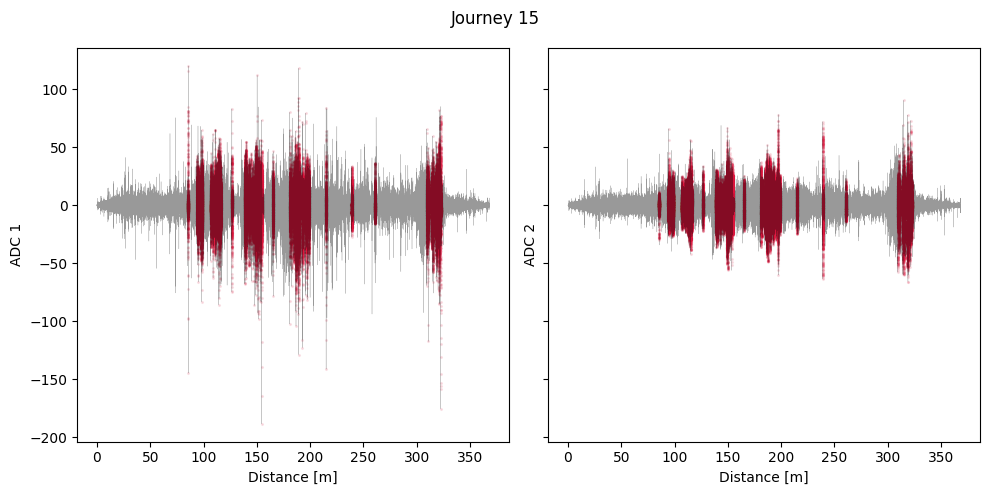

In [17]:
random_journey = np.random.randint(0, data.count_journeys())
print(f"Selected journey: {random_journey + 1}")

# we read the data
adc1_df = data.read_as_chuncked(random_journey, 'ADC1')
adc2_df = data.read_as_chuncked(random_journey, 'ADC2')

# we add a column for the distance
adc1_df["DTWDistance"] = np.nan
adc2_df["DTWDistance"] = np.nan

for j in trange(int(np.max(adc1_df["Bin"]))):
    try:
        time_start = np.min(adc1_df[adc1_df["Bin"] == j]["time"])
        time_end = np.max(adc1_df[adc1_df["Bin"] == j]["time"])

        bin_adc1 = adc1_df.loc[(adc1_df["time"] > time_start) & (adc1_df["time"] < time_end), "ch0"]
        bin_adc2 = adc2_df.loc[(adc2_df["time"] > time_start) & (adc2_df["time"] < time_end), "ch0"]

        length = np.min([len(bin_adc1), len(bin_adc2)])

        dwt_distance = tslearn.metrics.dtw(bin_adc1[:length], bin_adc2[:length])

        adc1_df.loc[(adc1_df["time"] > time_start) & (adc1_df["time"] < time_end), "DTWDistance"] = dwt_distance
        adc2_df.loc[(adc2_df["time"] > time_start) & (adc2_df["time"] < time_end), "DTWDistance"] = dwt_distance

    except:
        # this sometimes fails when the bin is too large (dtw needs to allocate too much memory).
        # Especially at the start of the journey. We ignore those.
        pass


fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(10, 5) )

 # Define 95 % percentile of max as threshold.
adc1_df_anomalies = adc1_df["DTWDistance"] >= np.nanpercentile(adc1_df["DTWDistance"], 95)
adc2_df_anomalies = adc2_df["DTWDistance"] >= np.nanpercentile(adc2_df["DTWDistance"], 95)


axs[0].scatter(adc1_df[adc1_df_anomalies]["distance"], adc1_df[adc1_df_anomalies]["ch0"], color=report.color_anomaly, alpha=0.1, s=1.5)
axs[0].plot(adc1_df["distance"], adc1_df["ch0"], color=report.color_sensor, linewidth=0.2, alpha=report.alpha_sonsor)
axs[0].set_ylabel("ADC 1")
axs[0].set_xlabel("Distance [m]")

axs[1].scatter(adc2_df[adc2_df_anomalies]["distance"], adc2_df[adc2_df_anomalies]["ch0"], color=report.color_anomaly, alpha=0.1, s=1.5)
axs[1].plot(adc2_df["distance"], adc2_df["ch0"], color=report.color_sensor, linewidth=0.2, alpha=report.alpha_sonsor)
axs[1].set_ylabel("ADC 2")
axs[1].set_xlabel("Distance [m]")

fig.suptitle(f"Journey {random_journey + 1}")
plt.tight_layout()

plt

Was wir sehen ist, dass hier durchaus Cluster gefunden werden. Leider haben wir durch das unüberwachte Lernen keine Möglichkeit, diese Cluster wirklich als Schadstelle zu identifizieren oder zu klassifizieren.

### Timeseries Anomaly Detection mit LSTM Autoencoders
Ein weiterer Ansatz ist es, die Daten als Zeitreihen zu betrachten und mit einem LSTM Autoencoder Anomalien zu finden. Wir bauen ein Neuronales Netz das seinen eigenen Input lernt. Wenn bei der Evaluierung der Reconstruction-Losses über einen Schwellwert liegt, dann liegt eine Anomalie vor.
Wir definieren den Schwellwert als das 95% Percentil des Losses der gelernten Daten.
Dieser Ansatz wurde inspiriert aus diesem [Paper](https://arxiv.org/pdf/2101.11539.pdf), das sich mit der Anwendung von Autoencodern auf Wälzlagermessugen beschäftigt.

Der Code liegt in der funktion `train_lstm_autoencoder`. Das Training der Netze dauert auf meinem Rechner mit allen Journeys bis zu 2 Tage. Teilweise wurden die Netze auch nicht fertig trainiert. Die modelle sind mit ihren trainierten weights im subfolder `results` gespeichert. Es wurden drei unterschiedliche Modelle unterschliedlicher Größe trainiert.
- Ein recht großes Model mit 198914 Parametern. Als input und output featues wurden die `ch0`- und `speed`-Werte der ADCs verwendet
- Ein kleineres Model mit 3074 Parametern. Als input und output featues wurden die `ch0`- und `speed`-Werte der ADCs verwendet
- Ein noch kleineres Model mit 1138 Parametern. Als input und output featues wurden statt der Beschleunigungsdate die fft Koeffizienten der Beschleunigungsdaten verwendet, da diese in der Analyse oben sichtbare Spikes gezeigt hatten.


Als input und auch als Output geben wir zusätzlich die momentane Geschwindingkeit der Lokomotive mit, da die Amplitude der vertikalen Beschleunigung sicher mit der Geschwindigkeit der Lokomitive korreliert.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67072     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 128)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            131584    
                                                                 
 dropout_1 (Dropout)         (None, 1, 128)            0         
                                                                 
 time_distributed (TimeDist  (None, 1, 2)              258       
 ributed)                                               

<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

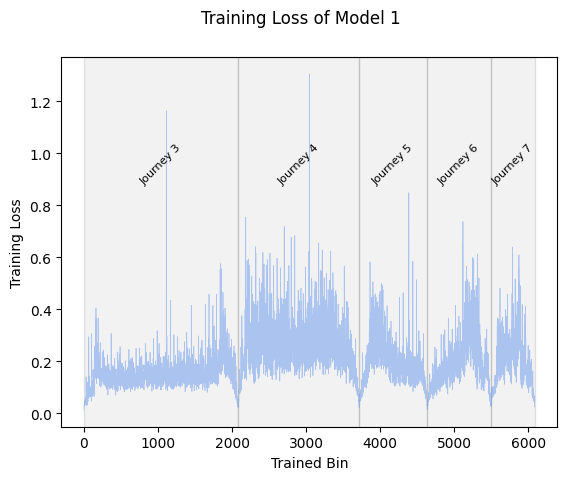

In [18]:
import tensorflow as tf

# load model
model = tf.keras.models.load_model(f"./results/model_1/model.keras")
model.summary()


loss_df = pd.read_pickle(f"./results/model_1/loss.pkl")
fig, axs = plt.subplots()
axs.plot(loss_df["Loss"],color=report.color_loss, label="Loss", linewidth=0.5, alpha=0.5)

for j in loss_df['Journey'].unique():
    rect_x = loss_df[loss_df['Journey'] == j].index[0]
    rect_y = loss_df[loss_df['Journey'] == j].index[-1]
    axs.axvspan(rect_x, rect_y, facecolor='gray', edgecolor="black", alpha=0.1,  linewidth=1)

    # write centered text
    text_x = loss_df[loss_df['Journey'] == j].index[0] + (loss_df[loss_df['Journey'] == j].index[-1] - loss_df[loss_df['Journey'] == j].index[0])/2
    text_y = np.max(loss_df["Loss"]) * 0.8
    axs.text(text_x, text_y, f"Journey {j + 1}", verticalalignment='top', horizontalalignment='center', fontsize=8, rotation=45)



axs.set_xlabel("Trained Bin")
axs.set_ylabel("Training Loss")

fig.suptitle("Training Loss of Model 1")

plt

Wir können nun den reconstruction loss für alle Bins berechnen und die Verteilung der Losses plotten. Wir definieren für unser model das 99 % Percentil der Losses als Schwellwert für eine Anomalie.

Managed to load scaler from disk.
109356/109356 [==============================] - 124s 1ms/step
(3499361,)
63685/63685 [==============================] - 93s 1ms/step
(2037914,)
42361/42361 [==============================] - 127s 3ms/step
(1355522,)
44796/44796 [==============================] - 137s 3ms/step
(1433443,)
36298/36298 [==============================] - 122s 3ms/step
(1161512,)


<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

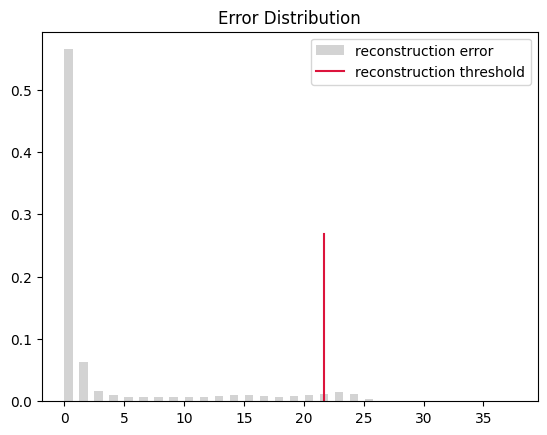

In [19]:
features=['speed', 'ch0']

# calculate standard scaler for our features
scaler = data.create_scaler_for_features('ADC1', features)

errors = []

for j in loss_df['Journey'].unique():
    df = data.read_as_chuncked(j, 'ADC1')

    # transform the features by the same scaler we used for training
    df_transformed = scaler.transform(df[features]).reshape(-1, 1, 2)

    # we predict the reconstruction
    prediction = model.predict(df_transformed)

    # we calculate reconstruction error (mean absolute error)
    mean_absolute_error = np.mean(np.abs(prediction - df_transformed), axis=1)[:, 1]

    print(mean_absolute_error.shape)
    errors.append(mean_absolute_error)


# we flatten the list of errors
training_errors = np.concatenate(errors)

# we define the threshold as the 95 percentile of the training error
max_train_error = np.percentile(training_errors, 95)

# we plot the distribution of the errors
plt.title('Error Distribution')
# plt.yscale("log")
hist = plt.hist(training_errors, bins=30, density=True, label="reconstruction error", color=report.color_error, width=0.7)

# we limit the hight of the threshold line, so it does not look too aggressive
y_ver_max = hist[0][0] * 0.8
plt.axvline(x=max_train_error, ymax=y_ver_max, color=report.color_anomaly, label="reconstruction threshold")
plt.legend()
plt

Wir schauen nun in den ersten 3 Journeys nach Anomalien. Die ersten beiden Journeys wurden nicht trainiert, die dritte Journey wurde trainiert.

122496/122496 [==============================] - 411s 3ms/step


<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

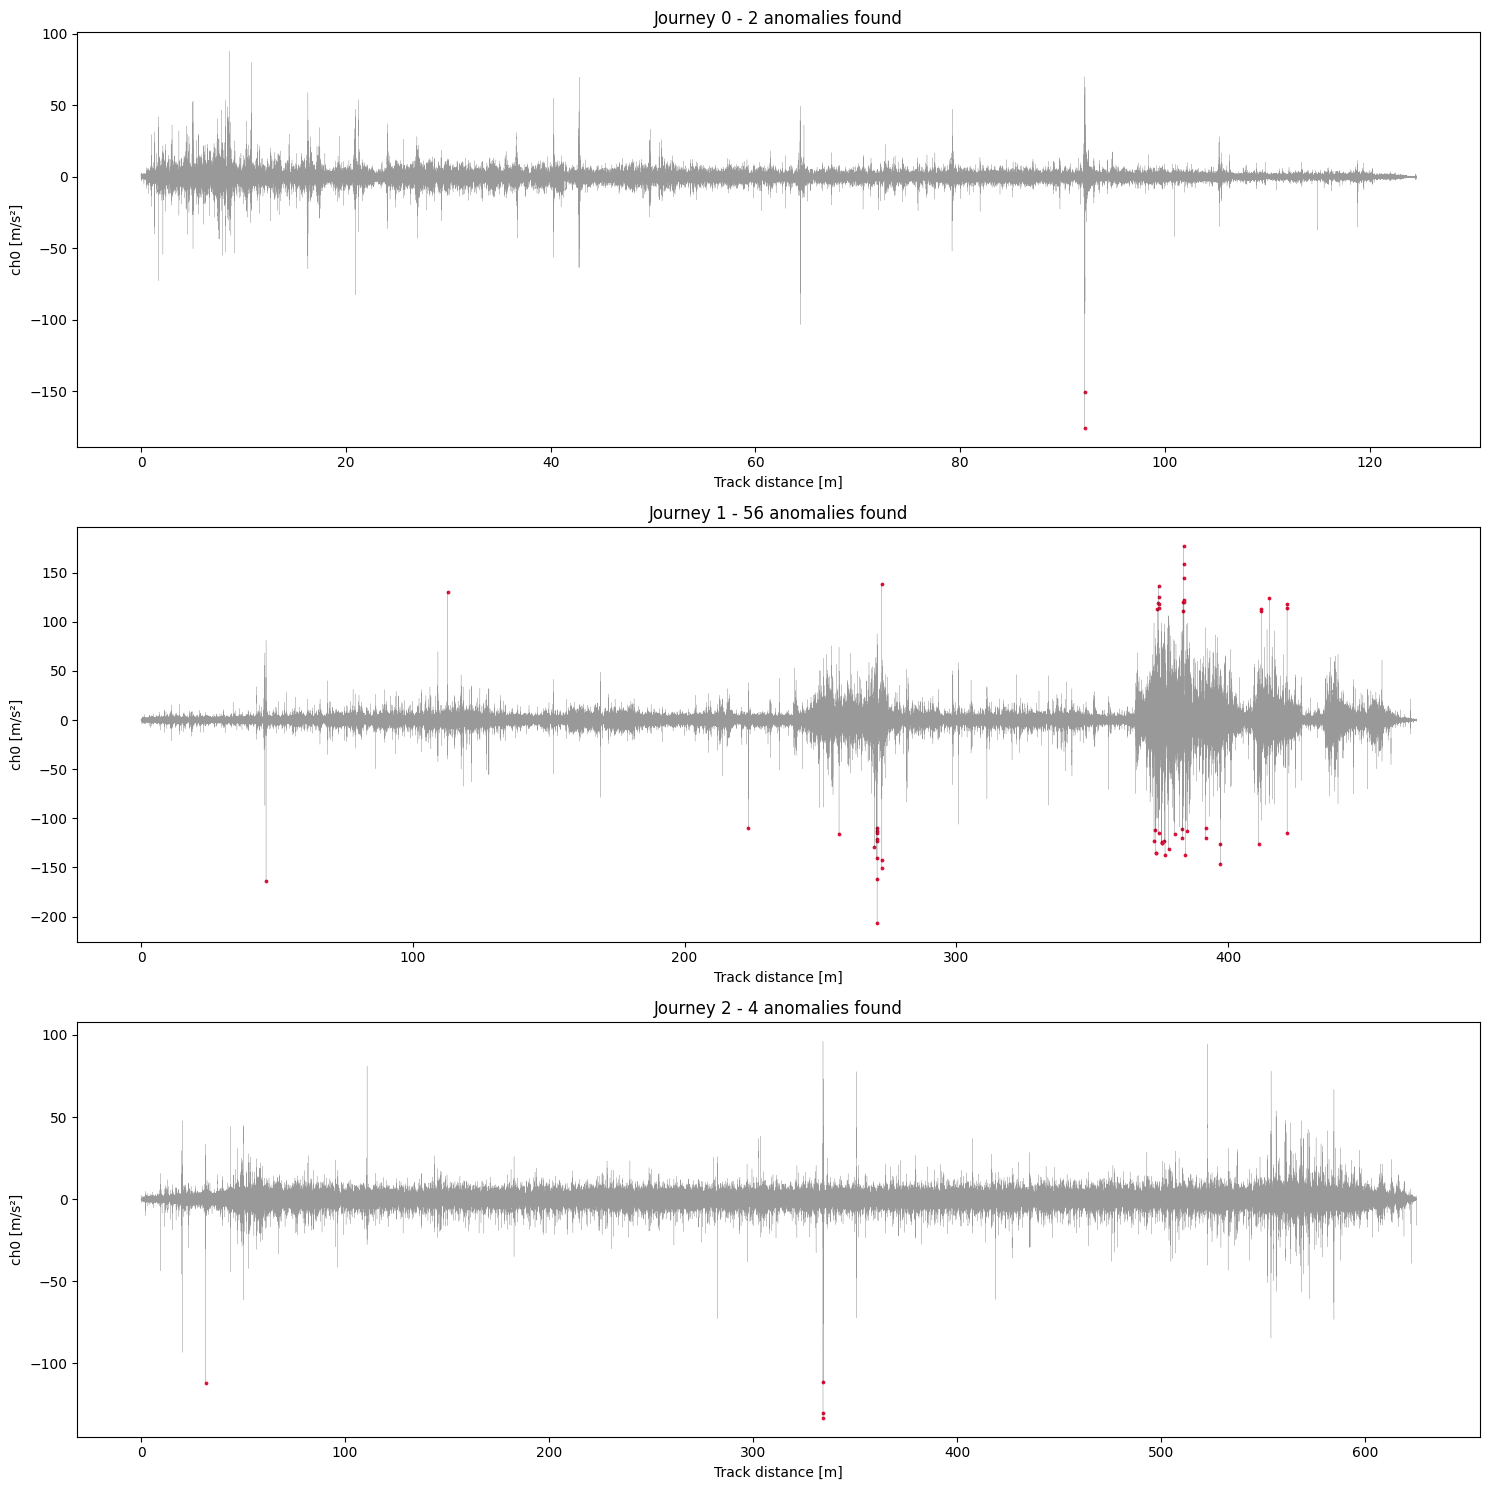

In [20]:
count_test_journeys = 3
fig, axs = plt.subplots(count_test_journeys, figsize=(15, 15))
for j in range(count_test_journeys):
    df_journey = data.read_data(j, 'ADC1')
    df_journey["speed"] = np.abs(df_journey["speed"])

    # scale intput data to all our recorded data
    features_transformed = scaler.transform(df_journey[features])
    # lets evaluate the model for this journey
    journey_data = features_transformed.reshape(-1, 1, 2)
    # this might take some time..
    test_predict = model.predict(journey_data)

    test_error = np.mean(np.abs(test_predict - journey_data), axis=1)

    # again we only look for the errors of the profile reconstruction
    anomalies = test_error[:, 1] >= max_train_error

    axs[j].set_title(f"Journey {j} - {np.sum(anomalies)} anomalies found")
    axs[j].scatter(df_journey[anomalies]["distance"], df_journey[anomalies]["ch0"], color=report.color_anomaly, s=3)
    axs[j].plot(df_journey["distance"], df_journey["ch0"], color=report.color_sensor, linewidth=0.2, alpha=report.alpha_sonsor)


for ax in axs.flat:
    ax.set(xlabel='Track distance [m]', ylabel='ch0 [m/s²]')

fig.tight_layout()
plt

Für das zweite Model gehen wir genau so vor. Dieses Model wurde mit allen Journeys trainiert.

Model summary:
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 16)             1216      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 4)              0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                                 
 time_distributed (TimeDist  (None, 1, 2)              34        
 ributed)                                   

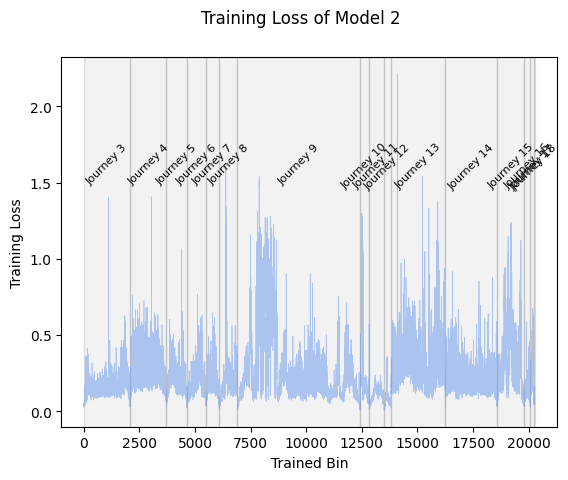

Managed to load scaler from disk.
Calculate loss of training to determine the threshold for anomalies.
11362/11362 [==============================] - 16s 1ms/step
max_train_error for model_version 2: 1.8641266358146273


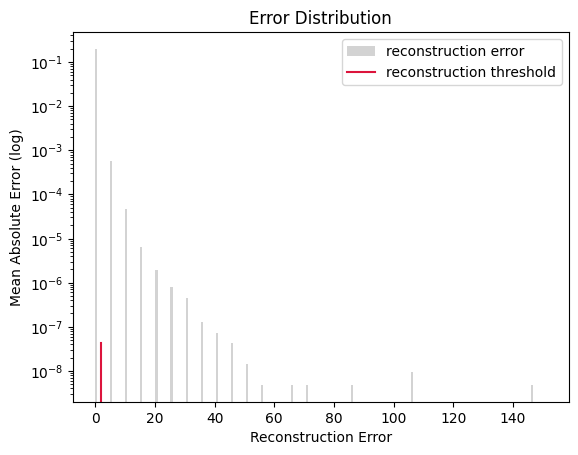

Managed to load scaler from disk.
122496/122496 [==============================] - 177s 1ms/step


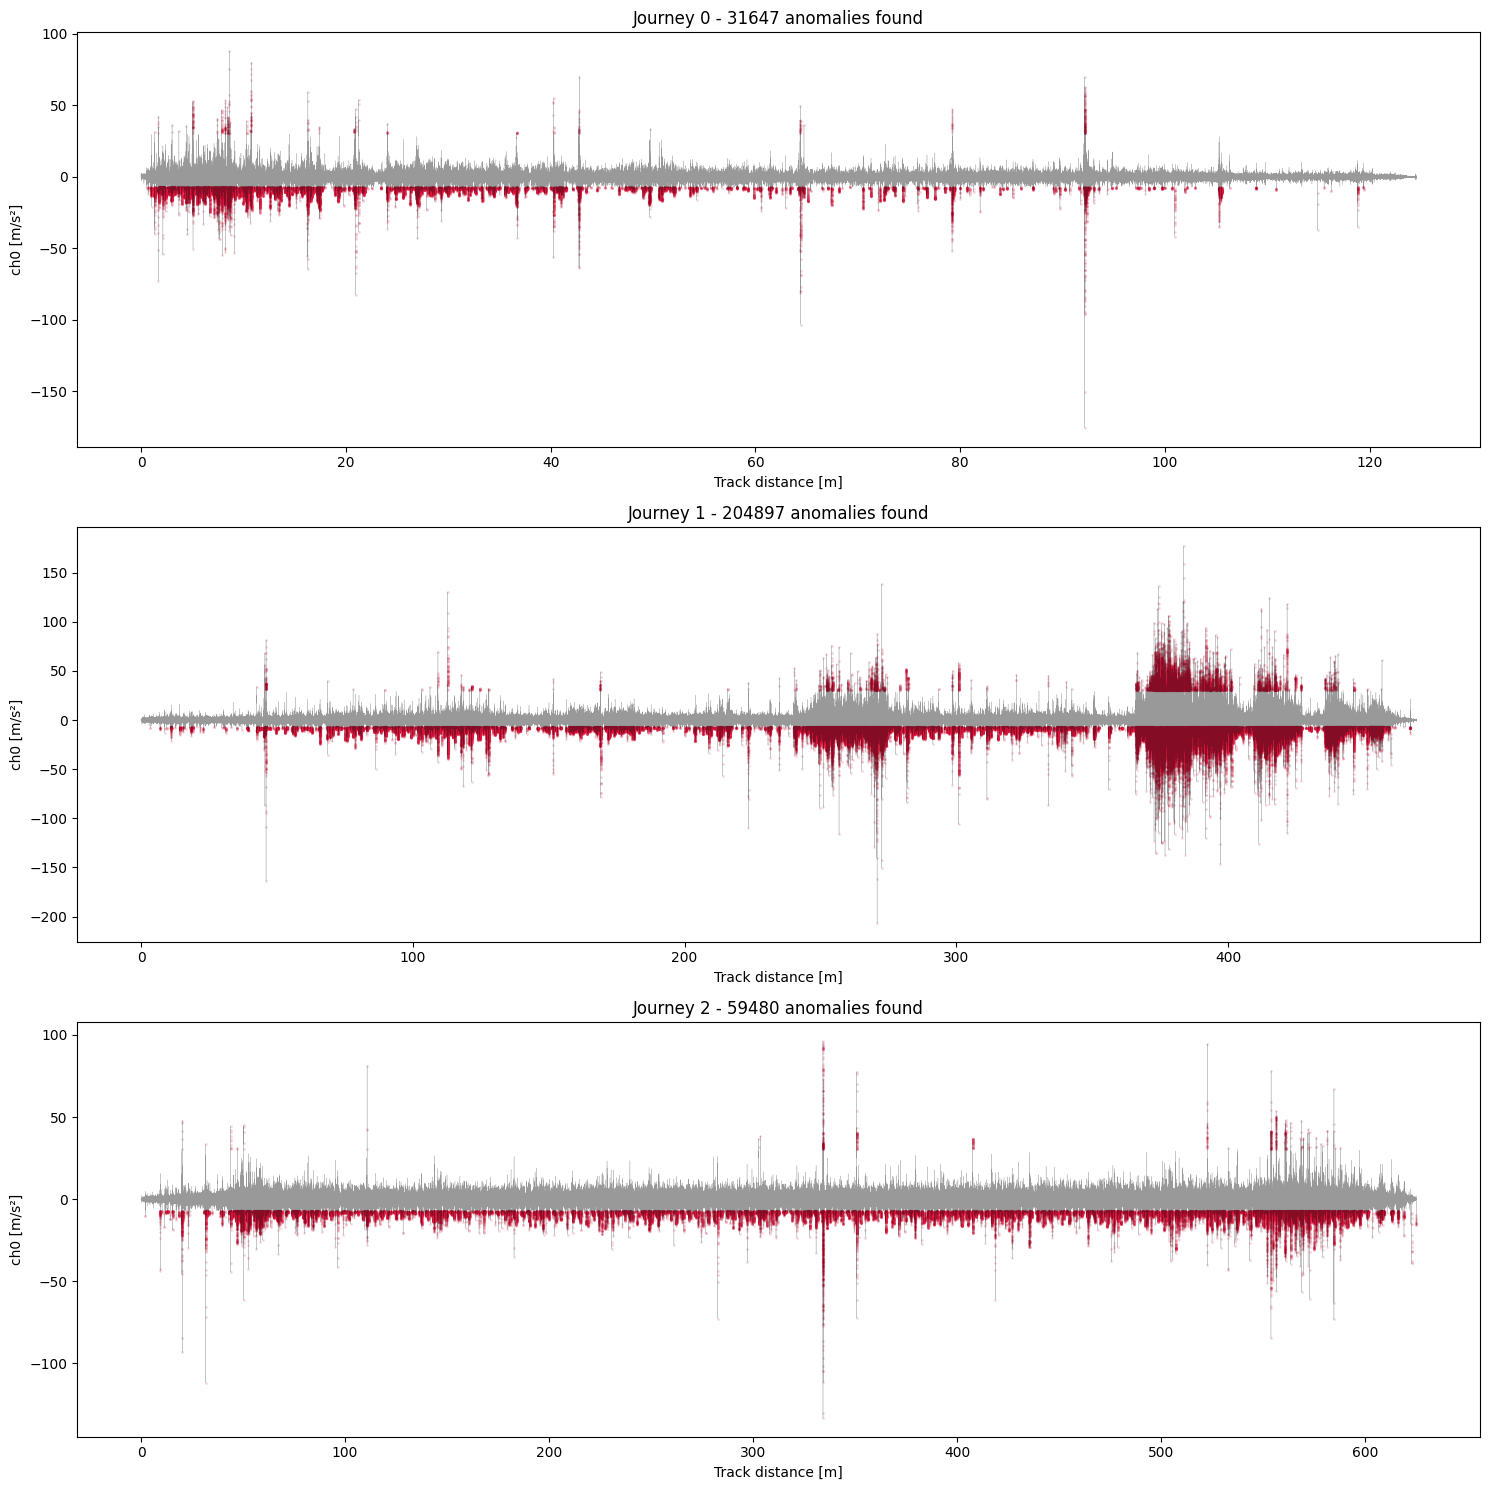

In [21]:
report.evaluate_lstm_autoencoder(
    model_version=2,
    features = ['speed', 'ch0'],
    percentil_threshold=95)

Für das dritte Model gehen wir ebenso so vor, bis dass wir die fft Koeffizienten der Beschleunigungsdaten als Features verwenden.

Model summary:
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 8)              352       
                                                                 
 lstm_1 (LSTM)               (None, 4)                 208       
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 4)              0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 8)              416       
                                                                 
 time_distributed (TimeDist  (None, 1, 2)              18        
 ributed)                                   

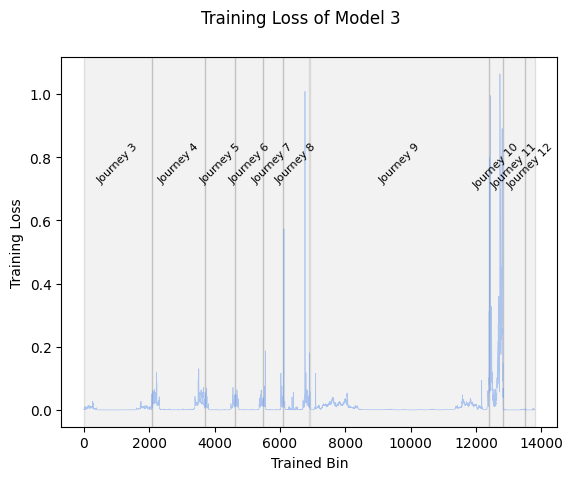

Managed to load scaler from disk.
Calculate loss of training to determine the threshold for anomalies.
60255/60255 [==============================] - 88s 1ms/step
max_train_error for model_version 3: 0.5171238180316411


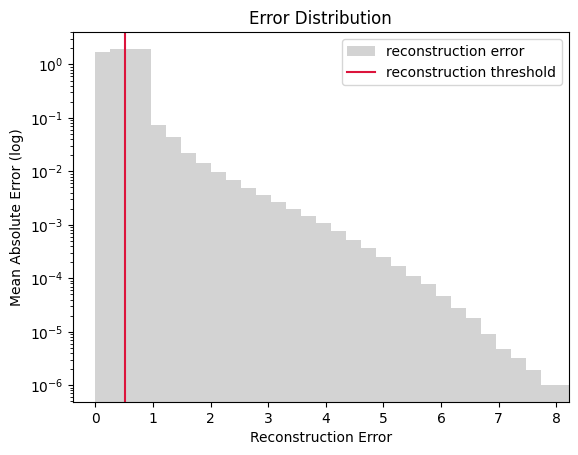

Managed to load scaler from disk.
122496/122496 [==============================] - 178s 1ms/step


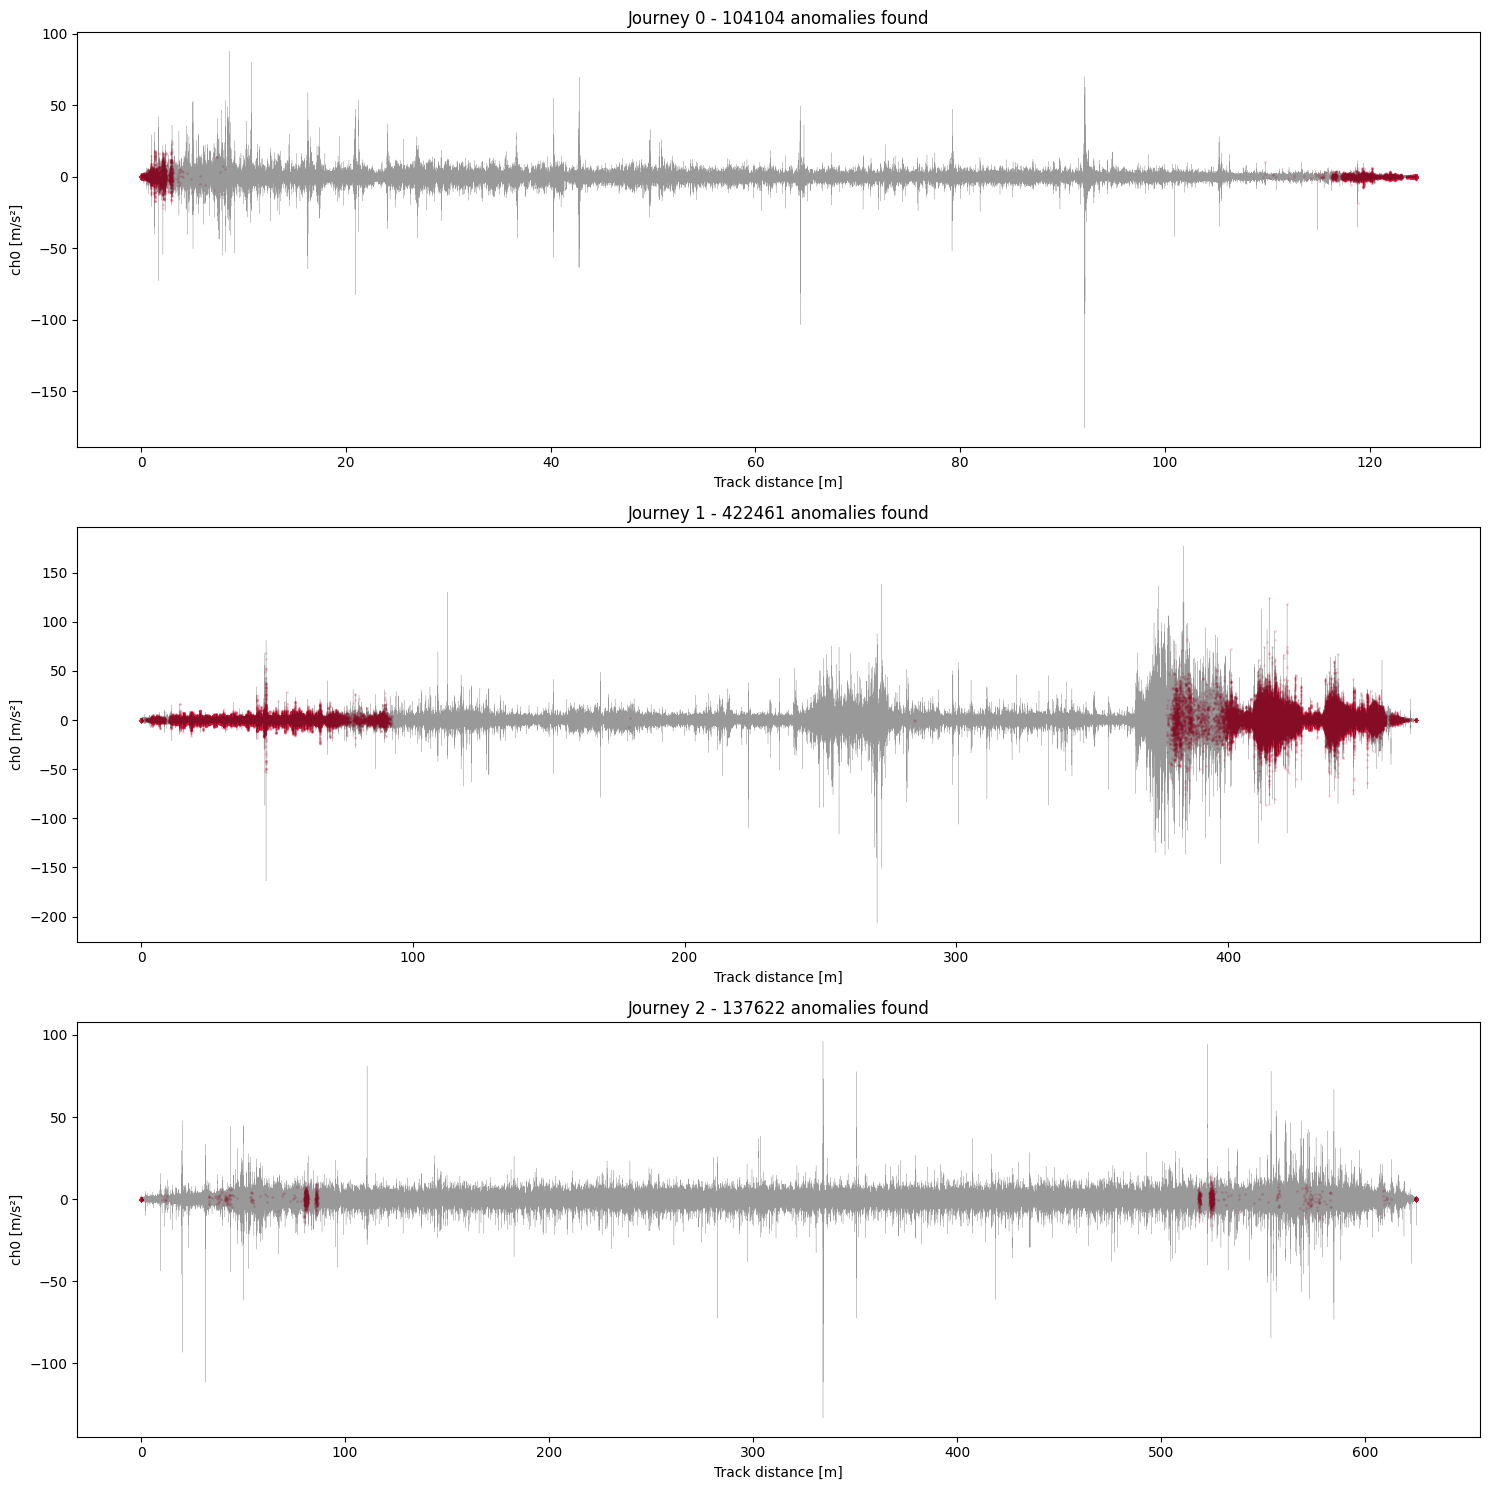

In [22]:
report.evaluate_lstm_autoencoder(
    model_version=3,
    features = ['speed', 'ch0_fft'],
    percentil_threshold=95)

### Zusammenfassung und Ausblick
In dieser Arbeit wurden drei verschiedene Ansätze zur Anomalieerkennung in den Daten des DLR vorgestellt. Der erste Ansatz basierte auf Feature Engineering und der Dimensionsreduzierung mittels PCA. Der zweite Ansatz basierte auf der Berechnung von Distanzen zwischen den vertikalen Beschleunigungen der beiden Achsen mittels DTW und der dritte Ansatz basierte auf der Verwendung von LSTM Autoencodern.
Der erste Ansatz ist gescheitert, ich konnte keine Cluster visualisieren, die auf Schadstellen hindeuten.
Im zweiten Ansatz konnten Anomalien gefunden werden. Die Regelmäßigkeit von ca. 20m deutet auf die Detektion von Schienenstößen hin, andere könnten von Weichen oder anderen Anomalien herrühren.
Der Ansatz der LSTM Autoencoder konnte ebenfalls Anomalien finden, insbesondere wenn das Model mit fft Koeffizienten trainiert wurde und das Modell nicht zu groß ist.


## Beurteilung der Ergebnisse
Das Anomalien gefunden wurden ist erstmal nicht verwunderlich, da nach Werten gesucht wurden, die oberhalb eines definierten Perzentils ligen, das Finden von Anomalien ist also keine Sensation. Die Idee nach Unähnlichkeinten zwischen beiden Rädern zu suchen ist aber grundsätzlich plausibel und hat durchaus zu nicht zufällig aussehenden Funden geführt.
Die LSTM Modelle, die mit den rohen Signalen trainiert wurden (Model 1 und 2) sind für mich eher enttäuschend gewesen. Das Training hat auf einem Konsumenten-Laptop über 20 Stunden gedauert und am Ende hat es eigentlich nur eine gerade Linie gelernt. Man kann in den Plots erkennen, dass es alles oberhalb und unterhalb des Schwellwertes als Annomalie detektiert.

Das Training der fft Koeffizienten hatte bessere Resultate und es war auch das kleinste Model mit den wenigsten Parametern. Diesen Ansatz würde ich weiter als vielversprechend ansehen.

Als Verbesserungsmöglichkeit würde ich das Model so ändern, dass ich die Geschwindigkeit weiter als Input in das Model geht, aber nicht in den Output. Das Lernen der Geschwindigkeit ist nicht von Interesse und wir haben diesen Reconstruction loss auch ignoriert.


### Vergleich der erkannten Annomalien zwischen DTW und LSTM Autoencoder

Zum Schluss wollen wir noch die Anomalien vergleichen, die wir mit dem DTW und dem LSTM Autoencoder gefunden. Dies tun wir anhand der als Test vorenthaltenden ersten beiden Journeys.

#### Vergleich mit der ersten Journey

  0%|          | 0/414 [00:00<?, ?it/s]

Managed to load scaler from disk.
Managed to load scaler from disk.
31489/31489 [==============================] - 44s 1ms/step


<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

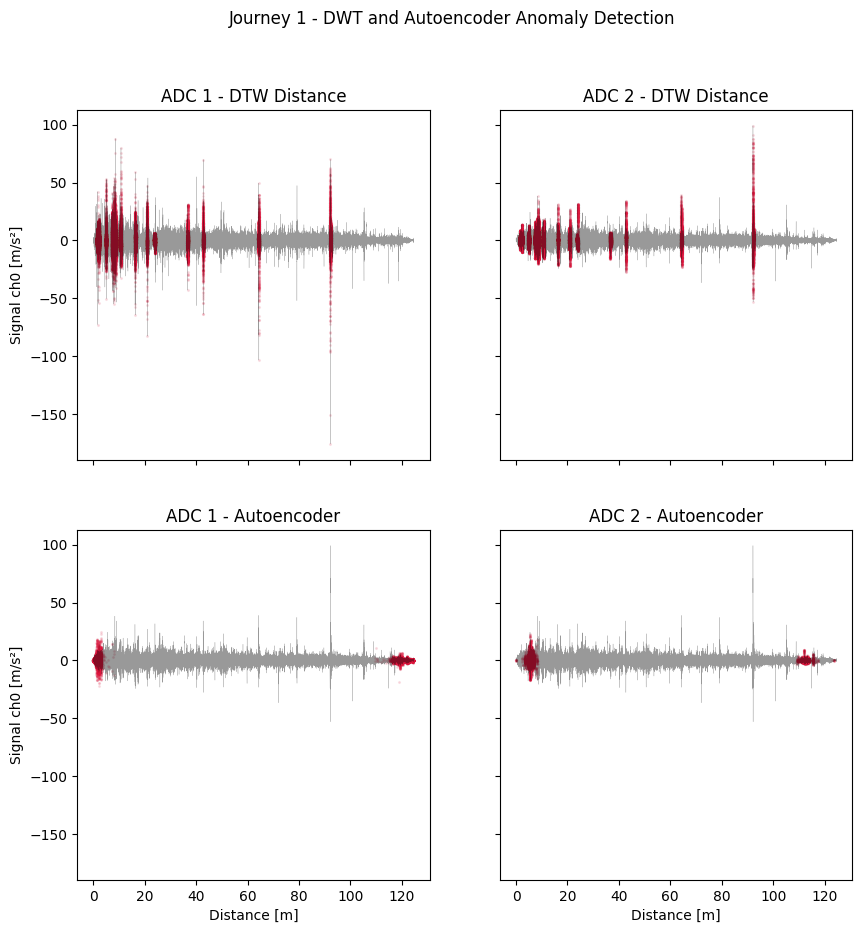

In [23]:
# Compare the anomalies found by the DTW and the LSTM Autoencoder for first journey
report.compare_dtw_with_autoencoder(
    journey=0,
    percentile_threshold=95)

#### Vergleich mit der zweiten Journey

  0%|          | 0/1562 [00:00<?, ?it/s]

Managed to load scaler from disk.
Managed to load scaler from disk.
92275/92275 [==============================] - 135s 1ms/step


<module 'matplotlib.pyplot' from 'C:\\Users\\murschac\\Documents\\data science\\AnalyseTechnischerDaten\\Hausarbeit\\src\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

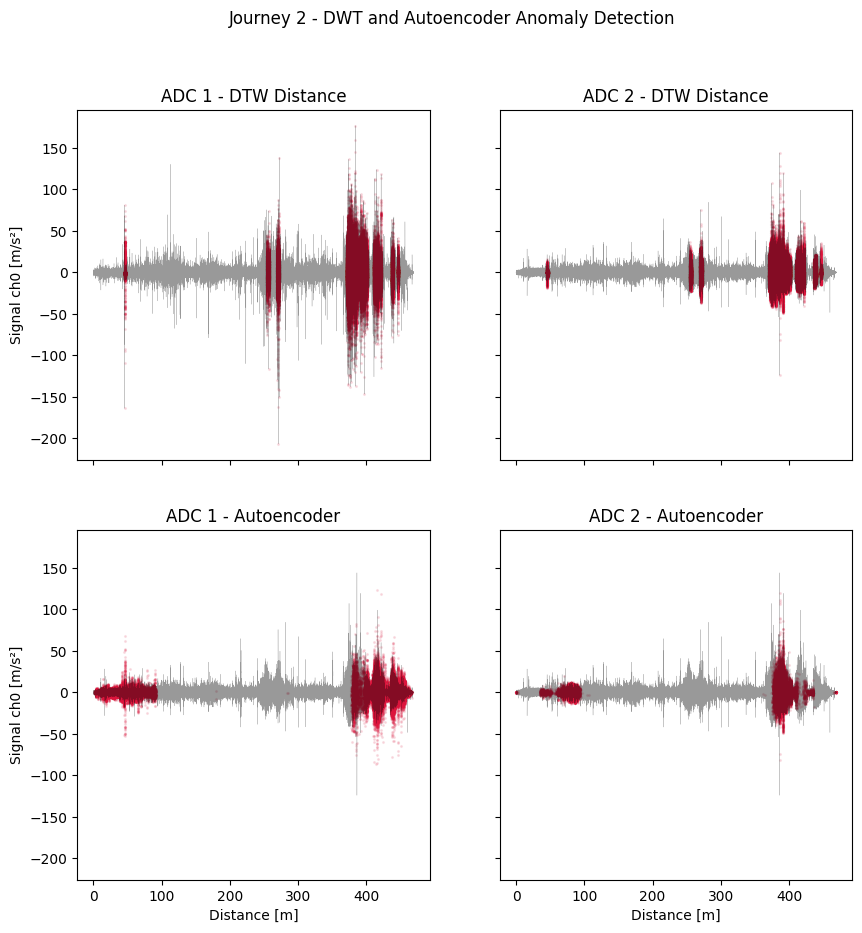

In [24]:
# Compare the anomalies found by the DTW and the LSTM Autoencoder for second journey
report.compare_dtw_with_autoencoder(
    journey=1,
    percentile_threshold=95)